In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
from pathlib import Path

# Define the file path and extraction path
file_path = '/content/drive/MyDrive/nlp_research/archive.zip'
extract_path = '/content/drive/MyDrive/nlp_research/extracted_files'

# Function to attempt extraction
def extract_zip(file_path, extract_path):
    try:
        # Create the extraction path if it doesn't exist
        Path(extract_path).mkdir(parents=True, exist_ok=True)

        # Try to open the zip file
        with zipfile.ZipFile(file_path, 'r') as zip_ref:
            # Extract all contents
            zip_ref.extractall(extract_path)
        return f"Files extracted successfully to {extract_path}"
    except zipfile.BadZipFile:
        return "Error: The file is not a zip file or it is corrupted."

# Attempt to extract the zip file
result = extract_zip(file_path, extract_path)
result



'Files extracted successfully to /content/drive/MyDrive/nlp_research/extracted_files'

In [ ]:
import os
import pandas as pd
import random

def extract_english_subtitles(base_path, num_movies=10):
    """
    Extract English subtitles from time-based CSV files for a random selection of movies.

    Args:
        base_path (str): Path to the base directory containing movie folders
        num_movies (int): Number of random movies to process

    Returns:
        list: Combined list of English subtitles from random movies
    """
    all_subtitles = []

    # Get list of all movie folders
    movie_folders = [f for f in os.listdir(base_path)
                    if os.path.isdir(os.path.join(base_path, f))]

    # If we have more movies than requested, randomly select subset
    if len(movie_folders) > num_movies:
        movie_folders = random.sample(movie_folders, num_movies)

    print(f"Selected {len(movie_folders)} movies for processing:")
    for folder in movie_folders:
        print(f"- {folder}")
    print()

    # Process selected movies
    for movie_folder in movie_folders:
        movie_path = os.path.join(base_path, movie_folder)
        time_based_file = os.path.join(movie_path, 'parallel_subtitle_time_based.csv')

        if os.path.exists(time_based_file):
            try:
                # Read the CSV file
                df = pd.read_csv(time_based_file)

                # Extract language_1 column (English subtitles)
                if 'language_1' in df.columns:
                    subtitles = df['language_1'].tolist()

                    # Add movie name as metadata
                    movie_subtitles = {
                        'movie': movie_folder,
                        'subtitles': subtitles
                    }

                    all_subtitles.append(movie_subtitles)
                    print(f"Successfully processed {movie_folder}")
                else:
                    print(f"Warning: No language_1 column found in {movie_folder}")

            except Exception as e:
                print(f"Error processing {movie_folder}: {str(e)}")

    return all_subtitles

def save_corpus(subtitles, output_file):
    """
    Save the combined subtitles to a text file.

    Args:
        subtitles (list): List of dictionaries containing movie names and subtitles
        output_file (str): Path to the output file
    """
    with open(output_file, 'w', encoding='utf-8') as f:
        # Write header with movie list
        f.write("=== Selected Movies ===\n")
        for i, movie_data in enumerate(subtitles, 1):
            f.write(f"{i}. {movie_data['movie']}\n")
        f.write("\n=== Subtitles ===\n")

        # Write subtitles
        for movie_data in subtitles:
            f.write(f"\n=== {movie_data['movie']} ===\n\n")
            for subtitle in movie_data['subtitles']:
                if pd.notna(subtitle):  # Check for NaN values
                    f.write(f"{subtitle}\n")

def main():
    # Configuration
    base_path = r'/content/drive/MyDrive/nlp_research/extracted_files/english to thai'
    output_file = '/content/drive/MyDrive/nlp_research/english_corpus_10movies.txt'
    num_movies = 10

    # Set random seed for reproducibility
    random.seed(42)  # You can change this number or remove it for different random selections

    # Extract subtitles
    print("Starting subtitle extraction...")
    subtitles = extract_english_subtitles(base_path, num_movies)

    # Save to file
    if subtitles:
        save_corpus(subtitles, output_file)
        print(f"\nCorpus saved to {output_file}")

        # Print statistics
        total_movies = len(subtitles)
        total_lines = sum(len(movie['subtitles']) for movie in subtitles)
        print(f"\nStatistics:")
        print(f"Total movies processed: {total_movies}")
        print(f"Total subtitle lines: {total_lines}")
    else:
        print("No subtitles were extracted")

if __name__ == "__main__":
    main()

Starting subtitle extraction...
Selected 10 movies for processing:
- Exodus_ Gods and Kings
- Arrival
- Kong_ Skull Island
- Jumanji_ The Next Level
- Interstellar
- Godzilla vs. Kong
- Dolittle
- Top Gun
- Cruella
- Star Wars_ Episode V - The Empire Strikes Back

Successfully processed Exodus_ Gods and Kings
Successfully processed Arrival
Successfully processed Kong_ Skull Island
Successfully processed Jumanji_ The Next Level
Successfully processed Interstellar
Successfully processed Godzilla vs. Kong
Successfully processed Dolittle
Successfully processed Top Gun
Successfully processed Cruella
Successfully processed Star Wars_ Episode V - The Empire Strikes Back

Corpus saved to /content/drive/MyDrive/nlp_research/english_corpus_10movies.txt

Statistics:
Total movies processed: 10
Total subtitle lines: 1146


In [ ]:
!pip install torch torchvision torchaudio transformers numpy
!pip install --upgrade accelerate

In [ ]:
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel

# Step 1: Load and preprocess the corpus
with open('/content/drive/MyDrive/nlp_research/english_corpus_10movies.txt', 'r') as file:
    subtitles = file.readlines()

def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation
    return text

cleaned_subtitles = [clean_text(line) for line in subtitles]

# Initialize BERT tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize sequences and labels
sequences = []
labels = []

for line in cleaned_subtitles:
    tokens = bert_tokenizer.encode(line, add_special_tokens=False)
    for i in range(2, len(tokens)):
        sequences.append(tokens[i-2:i])  # Two-word sequences
        labels.append(tokens[i])         # Next word as the label

# Step 2: Create a custom PyTorch Dataset
class TextDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        input_ids = torch.tensor(self.sequences[idx])
        attention_mask = torch.ones_like(input_ids)  # Assuming full attention
        label = torch.tensor(self.labels[idx])
        return input_ids, attention_mask, label

dataset = TextDataset(sequences, labels)
dataloader = DataLoader(dataset, batch_size=800, shuffle=True)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
from torch.optim import Adam

# Step 3: Define the enhanced model
class EnhancedNextWordPredictor(nn.Module):
    def __init__(self, bert_model, vocab_size):
        super(EnhancedNextWordPredictor, self).__init__()
        self.bert = bert_model
        self.attention = nn.MultiheadAttention(embed_dim=bert_model.config.hidden_size, num_heads=4, batch_first=True)
        self.fc = nn.Linear(bert_model.config.hidden_size, vocab_size)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask=attention_mask).last_hidden_state
        attn_output, _ = self.attention(bert_output, bert_output, bert_output)
        last_token_output = attn_output[:, -1, :]  # Use the last token's output
        logits = self.fc(last_token_output)       # Predict vocab probabilities
        return logits

# Load BERT model and initialize the enhanced model
bert_model = BertModel.from_pretrained("bert-base-uncased")
vocab_size = len(bert_tokenizer.get_vocab())
model = EnhancedNextWordPredictor(bert_model, vocab_size)

# Step 4: Set up loss, optimizer, and checkpointing
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=5e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Checkpoint to save the best model
best_loss = float('inf')
checkpoint_path = "/content/drive/MyDrive/nlp_research/best_model.pth"

# Training loop
for epoch in range(50):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids, attention_mask, targets = batch
        input_ids, attention_mask, targets = input_ids.to(device), attention_mask.to(device), targets.to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1} completed with average loss: {avg_loss}")

    # Save the best model
    if avg_loss < best_loss:
        best_loss = avg_loss
        torch.save(model.state_dict(), checkpoint_path)
        print("Best model saved.")


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1 completed with average loss: 8.354524282308725
Best model saved.
Epoch 2 completed with average loss: 6.666403418320876
Best model saved.
Epoch 3 completed with average loss: 6.341783017378587
Best model saved.
Epoch 4 completed with average loss: 6.045385661491981
Best model saved.
Epoch 5 completed with average loss: 5.807754164475661
Best model saved.
Epoch 6 completed with average loss: 5.600119444040152
Best model saved.
Epoch 7 completed with average loss: 5.420004331148588
Best model saved.
Epoch 8 completed with average loss: 5.264753268315242
Best model saved.
Epoch 9 completed with average loss: 5.118164069835956
Best model saved.
Epoch 10 completed with average loss: 4.98594552553617
Best model saved.
Epoch 11 completed with average loss: 4.859937550471379
Best model saved.
Epoch 12 completed with average loss: 4.735441934145414
Best model saved.
Epoch 13 completed with average loss: 4.619219222435585
Best model saved.
Epoch 14 completed with average loss: 4.50452304

In [ ]:
# Step 5: Define a function to predict the next word
def predict_next_word(model, bert_tokenizer, input_text):
    input_text = clean_text(input_text)
    tokens = bert_tokenizer.encode(input_text, add_special_tokens=False)
    if len(tokens) < 2:
        print("Input text must contain at least two words.")
        return None
    input_sequence = torch.tensor([tokens[-2:]]).to(device)
    attention_mask = torch.ones_like(input_sequence).to(device)
    model.eval()
    with torch.no_grad():
        logits = model(input_sequence, attention_mask)
    predicted_index = torch.argmax(logits, dim=-1).item()
    predicted_word = bert_tokenizer.decode([predicted_index])
    return predicted_word

# Example usage
input_text = "what the"
next_word = predict_next_word(model, bert_tokenizer, input_text)
print(f"Next word prediction for '{input_text}': {next_word}")


In [ ]:
!pip install ffmpeg-python openai-whisper


In [ ]:
import ffmpeg

def extract_audio(video_path, audio_path):
    ffmpeg.input(video_path).output(audio_path).run()

# Example usage
extract_audio(r'/content/8 Mile (2002) - The Lunch Truck Scene (6_10) _ Movieclips.mp4', 'output_audio.wav')

In [ ]:
import IPython.display as ipd
ipd.Audio('output_audio.wav')

In [ ]:
import whisper

def transcribe_audio(audio_path):
    # Load the model
    model = whisper.load_model("medium")  # Use "base" or larger models like "medium", "large" for better accuracy

    # Transcribe the audio
    result = model.transcribe(audio_path)
    return result['text']

# Example usage
transcribed_text = transcribe_audio('output_audio.wav')
print(transcribed_text)


In [ ]:
import whisper
from tqdm import tqdm
import librosa
import numpy as np
import torch
from typing import List, Tuple

def load_and_split_audio(audio_path: str, chunk_duration: int = 30) -> Tuple[List[np.ndarray], int]:
    """
    Load and split audio file into chunks for processing.

    Args:
        audio_path (str): Path to the audio file
        chunk_duration (int): Duration of each chunk in seconds

    Returns:
        Tuple[List[np.ndarray], int]: List of audio chunks and sample rate
    """
    try:
        # Load audio using librosa
        audio, sr = librosa.load(audio_path, sr=16000)  # Whisper expects 16kHz audio

        # Calculate number of samples per chunk
        chunk_samples = chunk_duration * sr
        total_chunks = int(np.ceil(len(audio) / chunk_samples))

        # Split audio into chunks
        chunks = []
        for i in range(total_chunks):
            start = i * chunk_samples
            end = min((i + 1) * chunk_samples, len(audio))
            chunk = audio[start:end]

            # Pad last chunk if necessary
            if len(chunk) < chunk_samples:
                chunk = np.pad(chunk, (0, chunk_samples - len(chunk)))

            chunks.append(chunk)

        return chunks, sr

    except Exception as e:
        raise Exception(f"Error loading audio file: {str(e)}")

def transcribe_audio_with_progress(audio_path: str, model_size: str = "base") -> str:
    """
    Transcribe audio file using OpenAI's Whisper model with progress bar.

    Args:
        audio_path (str): Path to the audio file
        model_size (str): Whisper model size ("tiny", "base", "small", "medium", "large")

    Returns:
        str: Transcribed text
    """
    try:
        # Load the model
        model = whisper.load_model(model_size)

        # Move model to GPU if available
        device = "cuda" if torch.cuda.is_available() else "cpu"
        model.to(device)

        # Load and split the audio
        chunks, sr = load_and_split_audio(audio_path)

        # Initialize empty transcription
        transcription = []

        # Process each chunk with progress bar
        for chunk in tqdm(chunks, desc="Transcribing Audio"):
            # Convert chunk to Mel spectrogram
            mel = whisper.log_mel_spectrogram(chunk).to(device)

            # Decode the audio
            result = model.transcribe(chunk, language="en")
            transcription.append(result["text"].strip())

        # Join all transcriptions with proper spacing
        return " ".join(transcription)

    except Exception as e:
        raise Exception(f"Error during transcription: {str(e)}")

def main():
    """Main function to demonstrate usage"""
    try:
        audio_path = "output_audio.wav"
        transcribed_text = transcribe_audio_with_progress(audio_path, model_size="base")
        print("Transcription:")
        print(transcribed_text)

    except Exception as e:
        print(f"Error: {str(e)}")

if __name__ == "__main__":
    main()

In [ ]:
def extract_english_subtitles(base_path, selected_movies):
    """
    Extract English subtitles from time-based CSV files for a specified list of movies.

    Args:
        base_path (str): Path to the base directory containing movie folders
        selected_movies (list): List of movie folder names to process

    Returns:
        list: Combined list of English subtitles from specified movies
    """
    all_subtitles = []

    print(f"Selected movies for processing:")
    for folder in selected_movies:
        print(f"- {folder}")
    print()

    # Process selected movies
    for movie_folder in selected_movies:
        movie_path = os.path.join(base_path, movie_folder)
        time_based_file = os.path.join(movie_path, 'parallel_subtitle_time_based.csv')

        if os.path.exists(time_based_file):
            try:
                # Read the CSV file
                df = pd.read_csv(time_based_file)

                # Extract language_1 column (English subtitles)
                if 'language_1' in df.columns:
                    subtitles = df['language_1'].tolist()

                    # Add movie name as metadata
                    movie_subtitles = {
                        'movie': movie_folder,
                        'subtitles': subtitles
                    }

                    all_subtitles.append(movie_subtitles)
                    print(f"Successfully processed {movie_folder}")
                else:
                    print(f"Warning: No language_1 column found in {movie_folder}")

            except Exception as e:
                print(f"Error processing {movie_folder}: {str(e)}")

    return all_subtitles

def main():
    # Configuration
    base_path = r'/content/drive/MyDrive/nlp_research/extracted_files/english to thai'
    output_file = '/content/drive/MyDrive/nlp_research/english_corpus_selected_movies.txt'
    selected_movies = [
        'Deadpool',
        'The Wolf of Wall Street',
        'Suicide Squad',
        'Bad Boys for Life',
        'Se7en',
        'Horrible Bosses',
        'The Departed',
        'The Hangover'
    ]

    # Extract subtitles
    print("Starting subtitle extraction...")
    subtitles = extract_english_subtitles(base_path, selected_movies)

    # Save to file
    if subtitles:
        save_corpus(subtitles, output_file)
        print(f"\nCorpus saved to {output_file}")

        # Print statistics
        total_movies = len(subtitles)
        total_lines = sum(len(movie['subtitles']) for movie in subtitles)
        print(f"\nStatistics:")
        print(f"Total movies processed: {total_movies}")
        print(f"Total subtitle lines: {total_lines}")
    else:
        print("No subtitles were extracted")

if __name__ == "__main__":
    main()


Starting subtitle extraction...
Selected movies for processing:
- Deadpool
- The Wolf of Wall Street
- Suicide Squad
- Bad Boys for Life
- Se7en
- Horrible Bosses
- The Departed
- The Hangover

Successfully processed Deadpool
Successfully processed Suicide Squad
Successfully processed Bad Boys for Life
Successfully processed Se7en
Successfully processed Horrible Bosses

Corpus saved to /content/drive/MyDrive/nlp_research/english_corpus_selected_movies.txt

Statistics:
Total movies processed: 5
Total subtitle lines: 565


In [ ]:
import torch
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from torch.optim import Adam
import numpy as np
from collections import deque
from torch.utils.data import Dataset

class ImprovedDQNAgent:
    def __init__(self, model, tokenizer, device, memory_size=10000, gamma=0.95,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay_steps=10000):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_steps = epsilon_decay_steps
        self.memory = deque(maxlen=memory_size)
        self.optimizer = Adam(model.parameters(), lr=0.001)
        self.vocab_size = len(tokenizer.get_vocab())
        self.steps = 0

    def update_epsilon(self):
        """Linear epsilon decay"""
        self.epsilon = max(
            self.epsilon_end,
            self.epsilon - (1.0 - self.epsilon_end) / self.epsilon_decay_steps
        )
        self.steps += 1

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() <= self.epsilon:
            # Improved exploration: sometimes choose from top-k most likely words
            with torch.no_grad():
                state_input = {k: v.to(self.device) for k, v in state.items()}
                q_values = self.model(state_input['input_ids'], state_input['attention_mask'])
                if random.random() < 0.3:  # 30% of exploration uses top-k
                    k = 10
                    top_k_actions = torch.topk(q_values, k).indices[0]
                    return q_values.scatter_(1, torch.tensor([[random.choice(top_k_actions)]]).to(self.device), 1.0)
            return torch.randn(self.vocab_size).to(self.device)

        with torch.no_grad():
            state_input = {k: v.to(self.device) for k, v in state.items()}
            q_values = self.model(state_input['input_ids'], state_input['attention_mask'])
            return q_values

    def compute_td_loss(self, batch_size):
        if len(self.memory) < batch_size:
            return 0

        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        # Convert to tensors and move to device
        states = {k: torch.cat([s[k] for s in states]) for k in states[0].keys()}
        next_states = {k: torch.cat([s[k] for s in next_states]) for k in next_states[0].keys()}
        actions = torch.stack([torch.argmax(a) for a in actions])
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        # Compute current Q values
        current_q_values = self.model(states['input_ids'].to(self.device),
                                    states['attention_mask'].to(self.device))
        current_q_values = current_q_values.gather(1, actions.unsqueeze(1).to(self.device))

        # Compute next Q values
        with torch.no_grad():
            next_q_values = self.model(next_states['input_ids'].to(self.device),
                                     next_states['attention_mask'].to(self.device))
            max_next_q_values = next_q_values.max(1)[0]
            expected_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        # Compute loss using Huber loss for stability
        loss = torch.nn.SmoothL1Loss()(current_q_values, expected_q_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

class ImprovedRewardSystem:
    def __init__(self, corpus_dataset, tokenizer, window_size=1000):
        self.corpus_dataset = corpus_dataset
        self.tokenizer = tokenizer
        self.context_frequency = {}
        self.window_size = window_size
        self.recent_predictions = deque(maxlen=window_size)
        self.recent_context_matches = deque(maxlen=window_size)
        self.build_context_map()

    def build_context_map(self):
        """Build n-gram frequency map from corpus with positional weighting"""
        print("Building context map...")
        for context, target in tqdm(self.corpus_dataset.samples):
            context_key =''.join(context)
            if context_key not in self.context_frequency:
                self.context_frequency[context_key] = {}
            if target not in self.context_frequency[context_key]:
                self.context_frequency[context_key][target] = 0
            self.context_frequency[context_key][target] += 1

    def get_context_score(self, context, predicted_word):
        """Calculate context score with position-aware weighting"""
        context_key =''.join(context)
        if context_key not in self.context_frequency:
            return 0.0

        total_occurrences = sum(self.context_frequency[context_key].values())
        word_occurrences = self.context_frequency[context_key].get(predicted_word, 0)

        base_score = word_occurrences / total_occurrences if total_occurrences > 0 else 0.0

        # Add positional weighting
        position_weight = 1.0
        for i, word in enumerate(context):
            if word == predicted_word:
                position_weight *= 0.8 ** (len(context) - i)  # Decay factor for distance

        return base_score * position_weight

    def calculate_dynamic_reward(self, predicted_word, target_word, context):
        """Calculate reward with multiple components"""
        # Basic correctness reward
        is_correct = (predicted_word == target_word)
        self.recent_predictions.append(is_correct)

        # Context alignment reward
        context_score = self.get_context_score(context, predicted_word)
        self.recent_context_matches.append(context_score > 0)

        # Calculate running metrics
        accuracy = sum(self.recent_predictions) / len(self.recent_predictions)
        context_rate = sum(self.recent_context_matches) / len(self.recent_context_matches)

        # Base reward calculation
        base_reward = 10.0 if is_correct else -5.0

        # Context bonus
        context_bonus = context_score * 5.0

        # Length similarity bonus
        length_similarity = 1.0 - (abs(len(predicted_word) - len(target_word)) /
                                 max(len(predicted_word), len(target_word)))
        length_bonus = length_similarity * 2.0

        # Semantic similarity bonus (using token overlap as proxy)
        pred_tokens = set(self.tokenizer.encode(predicted_word))
        target_tokens = set(self.tokenizer.encode(target_word))
        token_overlap = len(pred_tokens.intersection(target_tokens)) / len(pred_tokens.union(target_tokens))
        semantic_bonus = token_overlap * 3.0

        # Combine all components
        total_reward = base_reward + context_bonus + length_bonus + semantic_bonus

        # Scale reward based on recent performance to maintain challenge
        performance_scalar = 1.0 - (accuracy * 0.5)  # Reduce rewards as accuracy improves
        total_reward *= performance_scalar

        return total_reward, {
            'accuracy': accuracy * 100,
            'context_rate': context_rate * 100,
            'base_reward': base_reward,
            'context_bonus': context_bonus,
            'length_bonus': length_bonus,
           'semantic_bonus': semantic_bonus
        }

class ImprovedWordPredictionEnvironment:
    def __init__(self, tokenizer, corpus_dataset):
        self.tokenizer = tokenizer
        self.corpus_dataset = corpus_dataset
        self.reward_system = ImprovedRewardSystem(corpus_dataset, tokenizer)
        self.current_state = None
        self.target_word = None
        self.current_context = None
        self.episode_rewards = []
        self.samples = corpus_dataset.samples

    def reset(self):
        context, target = random.choice(self.samples)
        self.current_context = context
        self.target_word = target
        self.current_state = self.tokenizer(
           ''.join(context),
            return_tensors='pt',
            max_length=6,
            padding='max_length',
            truncation=True
        )
        return self.current_state

    def step(self, action):
        predicted_word = self.tokenizer.decode([torch.argmax(action).item()])
        reward, info = self.reward_system.calculate_dynamic_reward(
            predicted_word,
            self.target_word,
            self.current_context
        )
        self.episode_rewards.append(reward)

        # Update state
        current_words = self.tokenizer.decode(self.current_state['input_ids'][0])
        new_words =''.join(current_words.split()[1:] + [predicted_word])
        next_state = self.tokenizer(new_words, return_tensors='pt', max_length=6, padding='max_length', truncation=True)

        done = True
        return next_state, reward, done, info

class CustomCorpusDataset(Dataset):
    def __init__(self, corpus_path, tokenizer, context_size=3):
        """
        Initialize the dataset with a corpus file and tokenizer.

        Args:
            corpus_path (str): Path to the text corpus file
            tokenizer: The tokenizer to use for encoding text
            context_size (int): Number of words to use as context for prediction
        """
        self.tokenizer = tokenizer
        self.context_size = context_size
        self.samples = []

        # Read and process the corpus
        with open(corpus_path, 'r', encoding='utf-8') as f:
            text = f.read().strip()

        # Split into sentences and words
        sentences = [sent.strip() for sent in text.split('.') if sent.strip()]

        # Create context-target pairs
        for sentence in sentences:
            words = sentence.split()
            if len(words) <= context_size:
                continue

            # Generate samples using sliding window
            for i in range(len(words) - context_size):
                context = words[i:i + context_size]
                target = words[i + context_size]
                self.samples.append((context, target))

    def __len__(self):
        """Return the number of samples in the dataset"""
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Get a single sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve

        Returns:
            tuple: (context_tensor, target_tensor)
        """
        context, target = self.samples[idx]

        # Encode context and target
        context_encoding = self.tokenizer(
           ''.join(context),
            return_tensors='pt',
            max_length=6,
            padding='max_length',
            truncation=True
        )

        target_encoding = self.tokenizer(
            target,
            return_tensors='pt',
            max_length=6,
            padding='max_length',
            truncation=True
        )

        return {
            'context': context_encoding,
            'target': target_encoding['input_ids'].squeeze(),
            'raw_context': context,
            'raw_target': target
        }

def train_improved_dqn(model, corpus_path, tokenizer, device,
                      episodes=1000, batch_size=32,
                      save_interval=100, save_path='improved_dqn_checkpoints'):
    # Initialize environment and agent
    corpus_dataset = CustomCorpusDataset(corpus_path, tokenizer)
    env = ImprovedWordPredictionEnvironment(tokenizer, corpus_dataset)
    agent = ImprovedDQNAgent(model, tokenizer, device)

    # Tracking metrics
    rewards_history = []
    accuracy_history = []
    context_rate_history = []
    losses_history = []
    best_reward = float('-inf')

    os.makedirs(save_path, exist_ok=True)

    progress_bar = tqdm(range(episodes), desc='Training Improved DQN')
    for episode in progress_bar:
        state = env.reset()
        total_reward = 0
        episode_loss = 0
        done = False
        correct_predictions = 0
        context_matches = 0
        total_contexts = 0

        while not done:
            # Get action and interact with environment
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)

            # Store experience and update agent
            agent.remember(state, action, reward, next_state, done)
            loss = agent.compute_td_loss(batch_size)

            state = next_state
            total_reward += reward
            episode_loss += loss if loss else 0

            # Update exploration rate
            agent.update_epsilon()

            # Track correct predictions and context matches
            if info:
                if info['accuracy'] > 0:
                    correct_predictions += 1
                total_contexts += 1
                if info['context_rate'] > 0:
                    context_matches += 1

        # Record metrics
        avg_loss = episode_loss / (episode + 1)
        rewards_history.append(total_reward)
        losses_history.append(avg_loss)


        print(correct_predictions)

        # Calculate accuracy and context rate
        episode_accuracy = correct_predictions / (episode + 1) if episode > 0 else 0
        episode_context_rate = context_matches / total_contexts if total_contexts > 0 else 0

        accuracy_history.append(episode_accuracy)
        context_rate_history.append(episode_context_rate)

        # Update progress bar
        progress_bar.set_postfix({
            'Reward': f'{total_reward:.2f}',
            'Loss': f'{avg_loss:.4f}',
            'Epsilon': f'{agent.epsilon:.2f}',
            'Acc': f'{episode_accuracy*1000:.1f}%',
            'Context': f'{episode_context_rate*1000:.1f}%'
        })

        # Save best model
        if total_reward > best_reward:
            best_reward = total_reward
            torch.save({
                'episode': episode,
              'model_state_dict': model.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
              'reward': best_reward,
                'epsilon': agent.epsilon
            }, f'{save_path}/best_model.pth')

        # Plot training progress
        if (episode + 1) % save_interval == 0:
            plot_training_progress(
                rewards_history,
                accuracy_history,
                context_rate_history,
                losses_history,
                agent.epsilon
            )

    return rewards_history, accuracy_history, context_rate_history, losses_history

def plot_training_progress(rewards, accuracies, context_rates, losses, epsilon):
    plt.figure(figsize=(15, 12))

    # Plot rewards
    plt.subplot(3, 2, 1)
    plt.plot(rewards, label='Episode Reward')
    plt.plot(np.convolve(rewards, np.ones(20)/20, mode='valid'),
             label='Moving Average', alpha=0.7)
    plt.title('Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()

    # Plot accuracy and context rate
    plt.subplot(3, 2, 2)
    plt.plot(accuracies, label='Accuracy')
    plt.plot(context_rates, label='Context Rate')
    plt.title('Performance Metrics')
    plt.xlabel('Episode')
    plt.ylabel('Percentage')
    plt.legend()

    # Plot loss
    plt.subplot(3, 2, 3)
    plt.plot(losses)
    plt.title('Loss per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Loss')

    # Plot epsilon decay
    plt.subplot(3, 2, 4)
    plt.axhline(y=epsilon, color='r', linestyle='-', label='Current ε')
    plt.title('Exploration Rate (ε)')
    plt.xlabel('Episode')
    plt.ylabel('ε')
    plt.legend()

    plt.tight_layout()
    plt.show()

<ipython-input-21-b6d9d7bf2a71>:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Loaded pretrained weights directly from checkpoint
Successfully loaded model and tokenizer
Building context map...


Training Improved DQN:   0%|          | 0/1000 [00:00<?, ?it/s, Reward=-2.80, Loss=0.0000, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:   0%|          | 1/1000 [00:06<1:51:20,  6.69s/it, Reward=-2.70, Loss=0.0000, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   0%|          | 3/1000 [00:12<1:04:47,  3.90s/it, Reward=-2.57, Loss=0.0000, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:   0%|          | 4/1000 [00:17<1:10:29,  4.25s/it, Reward=-2.17, Loss=0.0000, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:   0%|          | 5/1000 [00:20<1:01:21,  3.70s/it, Reward=-2.00, Loss=0.0000, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:   1%|          | 6/1000 [00:23<57:17,  3.46s/it, Reward=-1.90, Loss=0.0000, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:   1%|          | 7/1000 [00:28<1:09:09,  4.18s/it, Reward=-1.50, Loss=0.0000, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   2%|▏         | 18/1000 [00:35<12:54,  1.27it/s, Reward=-1.50, Loss=0.0000, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0
0
0
0
0
0
0
0
0


Training Improved DQN:   3%|▎         | 30/1000 [00:35<04:22,  3.69it/s, Reward=-1.79, Loss=0.0000, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0
0
0
0
0
0
0
0
0
0
0
0


Training Improved DQN:   3%|▎         | 30/1000 [00:36<04:22,  3.69it/s, Reward=-3.17, Loss=0.4485, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   3%|▎         | 30/1000 [00:36<04:22,  3.69it/s, Reward=-1.80, Loss=0.1007, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   4%|▎         | 35/1000 [00:36<03:33,  4.53it/s, Reward=-2.50, Loss=0.0399, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   4%|▎         | 35/1000 [00:36<03:33,  4.53it/s, Reward=-2.50, Loss=0.0141, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   4%|▍         | 39/1000 [00:37<03:07,  5.14it/s, Reward=-1.83, Loss=0.0219, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   4%|▍         | 42/1000 [00:37<02:52,  5.54it/s, Reward=-1.50, Loss=0.0134, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   4%|▍         | 44/1000 [00:37<02:46,  5.76it/s, Reward=-2.57, Loss=0.0060, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   5%|▍         | 46/1000 [00:37<02:37,  6.07it/s, Reward=-2.00, Loss=0.0071, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   5%|▍         | 48/1000 [00:38<02:28,  6.39it/s, Reward=-2.70, Loss=0.0036, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   5%|▌         | 50/1000 [00:38<02:26,  6.49it/s, Reward=-2.54, Loss=0.0049, Epsilon=1.00, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   5%|▌         | 52/1000 [00:38<02:20,  6.73it/s, Reward=-3.13, Loss=0.0030, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   5%|▌         | 54/1000 [00:38<02:09,  7.33it/s, Reward=-1.50, Loss=0.0074, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   6%|▌         | 56/1000 [00:39<01:59,  7.87it/s, Reward=-2.60, Loss=0.0044, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   6%|▌         | 58/1000 [00:39<01:52,  8.38it/s, Reward=-2.17, Loss=0.0029, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   6%|▌         | 60/1000 [00:39<01:52,  8.34it/s, Reward=-2.61, Loss=0.0075, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   6%|▌         | 62/1000 [00:39<01:48,  8.67it/s, Reward=-2.24, Loss=0.0017, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   6%|▋         | 64/1000 [00:40<01:45,  8.84it/s, Reward=-2.90, Loss=0.0046, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   7%|▋         | 66/1000 [00:40<01:44,  8.90it/s, Reward=-1.50, Loss=0.0051, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   7%|▋         | 68/1000 [00:40<01:45,  8.83it/s, Reward=-1.90, Loss=0.0037, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   7%|▋         | 70/1000 [00:40<01:45,  8.79it/s, Reward=-2.50, Loss=0.0048, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   7%|▋         | 72/1000 [00:40<01:43,  8.98it/s, Reward=-2.83, Loss=0.0027, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   7%|▋         | 74/1000 [00:41<01:43,  8.93it/s, Reward=-2.17, Loss=0.0044, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   8%|▊         | 76/1000 [00:41<01:43,  8.95it/s, Reward=-1.50, Loss=0.0028, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   8%|▊         | 78/1000 [00:41<01:45,  8.76it/s, Reward=-2.30, Loss=0.0063, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   8%|▊         | 80/1000 [00:41<01:43,  8.92it/s, Reward=-2.09, Loss=0.0020, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   8%|▊         | 82/1000 [00:42<01:42,  8.98it/s, Reward=-2.83, Loss=0.0026, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   8%|▊         | 84/1000 [00:42<01:41,  9.02it/s, Reward=-2.83, Loss=0.0050, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   9%|▊         | 86/1000 [00:42<01:41,  9.04it/s, Reward=-3.00, Loss=0.0014, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   9%|▉         | 88/1000 [00:42<01:42,  8.92it/s, Reward=-1.79, Loss=0.0024, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   9%|▉         | 90/1000 [00:42<01:41,  8.98it/s, Reward=-1.90, Loss=0.0024, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   9%|▉         | 92/1000 [00:43<01:41,  8.97it/s, Reward=-2.00, Loss=0.0029, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:   9%|▉         | 94/1000 [00:43<01:40,  9.02it/s, Reward=-3.04, Loss=0.0018, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  10%|▉         | 96/1000 [00:43<01:45,  8.59it/s, Reward=-3.33, Loss=0.0020, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  10%|▉         | 98/1000 [00:43<01:42,  8.79it/s, Reward=-2.36, Loss=0.0038, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  10%|▉         | 99/1000 [00:44<01:41,  8.85it/s, Reward=-2.61, Loss=0.0013, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


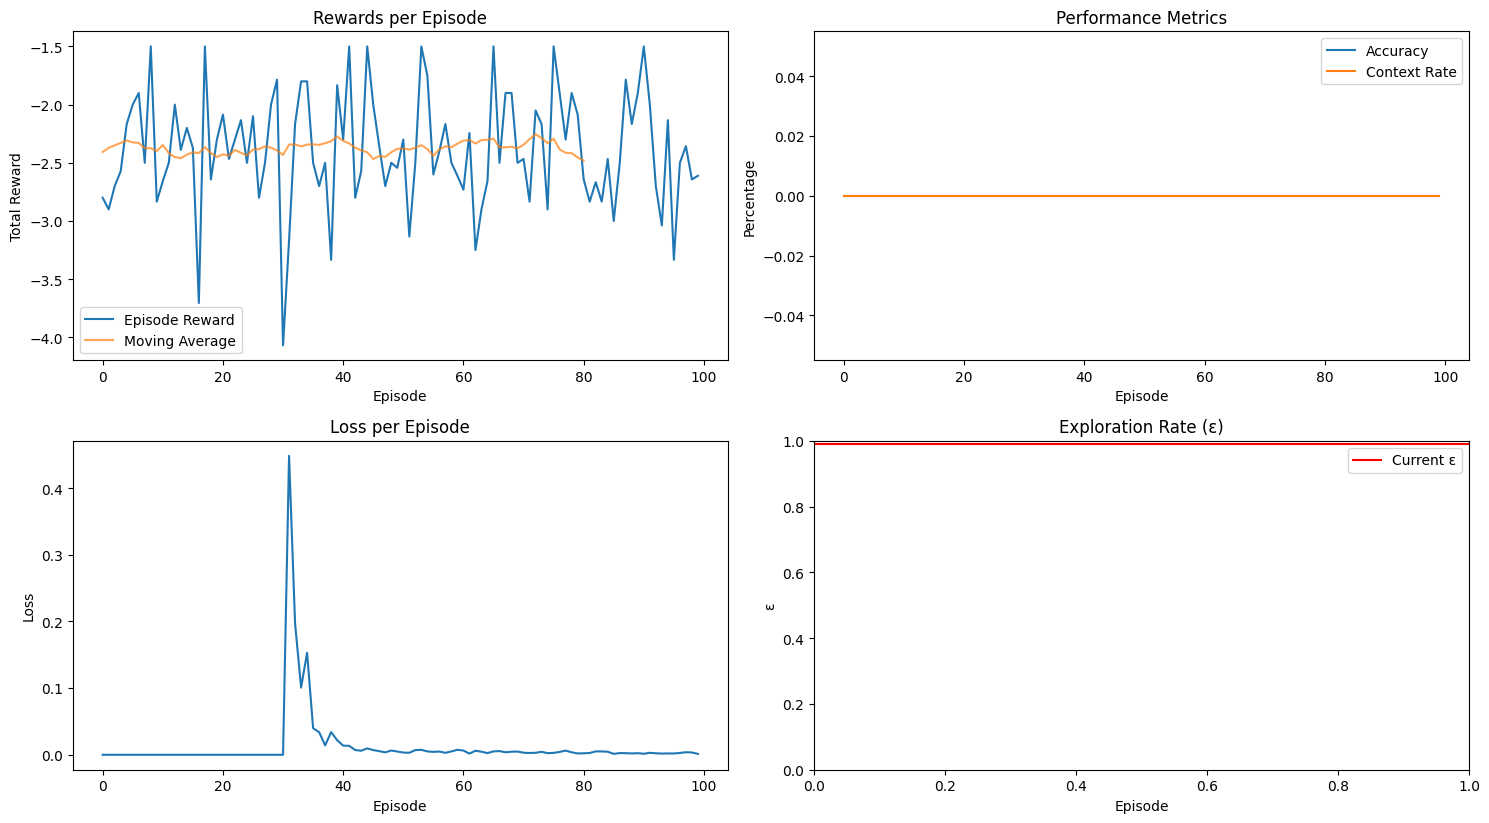

Training Improved DQN:  10%|█         | 102/1000 [00:44<03:05,  4.85it/s, Reward=-2.00, Loss=0.0027, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  10%|█         | 104/1000 [00:45<02:21,  6.32it/s, Reward=-2.25, Loss=0.0019, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  11%|█         | 106/1000 [00:45<02:00,  7.44it/s, Reward=-1.50, Loss=0.0034, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  11%|█         | 108/1000 [00:45<01:53,  7.88it/s, Reward=-1.75, Loss=0.0019, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  11%|█         | 110/1000 [00:45<02:05,  7.10it/s, Reward=-1.50, Loss=0.0013, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  11%|█         | 112/1000 [00:46<02:06,  6.99it/s, Reward=-2.29, Loss=0.0020, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  11%|█▏        | 114/1000 [00:46<01:58,  7.45it/s, Reward=-2.17, Loss=0.0020, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  12%|█▏        | 116/1000 [00:46<02:00,  7.35it/s, Reward=-2.67, Loss=0.0019, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  12%|█▏        | 118/1000 [00:46<01:57,  7.53it/s, Reward=-1.79, Loss=0.0020, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  12%|█▏        | 120/1000 [00:47<01:51,  7.89it/s, Reward=-2.64, Loss=0.0015, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  12%|█▏        | 122/1000 [00:47<01:57,  7.46it/s, Reward=-2.50, Loss=0.0016, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  12%|█▏        | 124/1000 [00:47<01:51,  7.85it/s, Reward=-2.05, Loss=0.0011, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  13%|█▎        | 126/1000 [00:48<01:55,  7.58it/s, Reward=-3.10, Loss=0.0019, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  13%|█▎        | 128/1000 [00:48<01:55,  7.54it/s, Reward=-2.36, Loss=0.0009, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  13%|█▎        | 130/1000 [00:48<01:55,  7.56it/s, Reward=-2.30, Loss=0.0013, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  13%|█▎        | 132/1000 [00:49<02:29,  5.80it/s, Reward=-3.52, Loss=0.0018, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  13%|█▎        | 134/1000 [00:49<02:34,  5.61it/s, Reward=-3.14, Loss=0.0014, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  14%|█▎        | 136/1000 [00:49<02:35,  5.57it/s, Reward=-1.50, Loss=0.0010, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  14%|█▍        | 138/1000 [00:50<02:35,  5.53it/s, Reward=-2.58, Loss=0.0008, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  14%|█▍        | 140/1000 [00:50<02:29,  5.76it/s, Reward=-2.50, Loss=0.0024, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  14%|█▍        | 142/1000 [00:50<02:21,  6.05it/s, Reward=-2.91, Loss=0.0012, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  14%|█▍        | 144/1000 [00:51<02:40,  5.34it/s, Reward=-2.50, Loss=0.0006, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  15%|█▍        | 146/1000 [00:51<02:34,  5.51it/s, Reward=-1.90, Loss=0.0015, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  15%|█▍        | 147/1000 [00:51<02:44,  5.18it/s, Reward=-2.36, Loss=0.0015, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  15%|█▍        | 149/1000 [00:52<02:42,  5.23it/s, Reward=-3.00, Loss=0.0021, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  15%|█▌        | 151/1000 [00:52<02:39,  5.33it/s, Reward=-3.00, Loss=0.0011, Epsilon=0.99, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  15%|█▌        | 153/1000 [00:52<02:29,  5.67it/s, Reward=-1.83, Loss=0.0007, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  16%|█▌        | 155/1000 [00:53<02:39,  5.29it/s, Reward=-2.50, Loss=0.0022, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  16%|█▌        | 157/1000 [00:53<02:26,  5.77it/s, Reward=-1.79, Loss=0.0008, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  16%|█▌        | 159/1000 [00:53<02:07,  6.59it/s, Reward=-3.20, Loss=0.0019, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  16%|█▌        | 161/1000 [00:54<01:51,  7.52it/s, Reward=-1.50, Loss=0.0008, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  16%|█▋        | 163/1000 [00:54<01:42,  8.16it/s, Reward=-3.00, Loss=0.0009, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  16%|█▋        | 165/1000 [00:54<01:40,  8.34it/s, Reward=-2.54, Loss=0.0005, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  17%|█▋        | 167/1000 [00:54<01:36,  8.59it/s, Reward=-2.70, Loss=0.0012, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  17%|█▋        | 169/1000 [00:55<01:40,  8.31it/s, Reward=-2.80, Loss=0.0005, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  17%|█▋        | 171/1000 [00:55<01:38,  8.43it/s, Reward=-2.24, Loss=0.0007, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  17%|█▋        | 173/1000 [00:55<01:40,  8.21it/s, Reward=-2.89, Loss=0.0010, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  18%|█▊        | 175/1000 [00:55<01:36,  8.54it/s, Reward=-2.82, Loss=0.0011, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  18%|█▊        | 177/1000 [00:56<01:34,  8.70it/s, Reward=-2.94, Loss=0.0017, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  18%|█▊        | 179/1000 [00:56<01:34,  8.67it/s, Reward=-2.93, Loss=0.0004, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  18%|█▊        | 181/1000 [00:56<01:33,  8.80it/s, Reward=-2.17, Loss=0.0006, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  18%|█▊        | 183/1000 [00:56<01:34,  8.67it/s, Reward=-2.61, Loss=0.0009, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  18%|█▊        | 185/1000 [00:56<01:32,  8.81it/s, Reward=-2.17, Loss=0.0003, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  19%|█▊        | 187/1000 [00:57<01:32,  8.79it/s, Reward=-2.81, Loss=0.0008, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  19%|█▉        | 189/1000 [00:57<01:33,  8.64it/s, Reward=-1.50, Loss=0.0013, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  19%|█▉        | 191/1000 [00:57<01:33,  8.63it/s, Reward=-2.17, Loss=0.0012, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  19%|█▉        | 193/1000 [00:57<01:31,  8.78it/s, Reward=-1.83, Loss=0.0012, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  20%|█▉        | 195/1000 [00:58<01:31,  8.83it/s, Reward=-3.05, Loss=0.0007, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  20%|█▉        | 197/1000 [00:58<01:33,  8.58it/s, Reward=-2.00, Loss=0.0006, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  20%|█▉        | 199/1000 [00:58<01:35,  8.37it/s, Reward=-2.83, Loss=0.0003, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  20%|█▉        | 199/1000 [00:58<01:35,  8.37it/s, Reward=-1.50, Loss=0.0004, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0


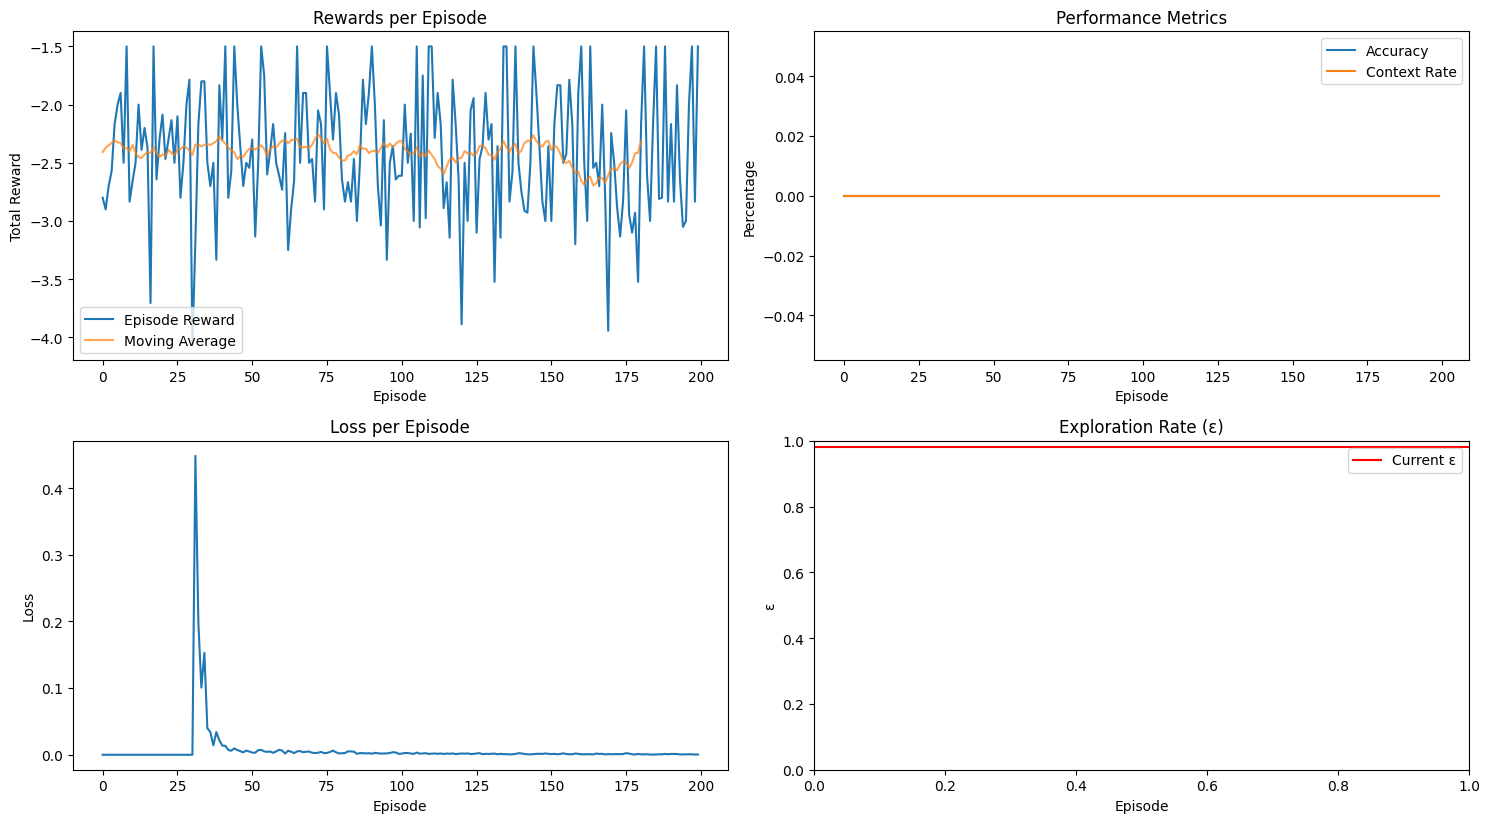

Training Improved DQN:  20%|██        | 202/1000 [00:59<02:52,  4.64it/s, Reward=-2.70, Loss=0.0004, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  20%|██        | 204/1000 [00:59<02:11,  6.08it/s, Reward=-2.64, Loss=0.0004, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  21%|██        | 206/1000 [01:00<01:50,  7.16it/s, Reward=-2.69, Loss=0.0004, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  21%|██        | 208/1000 [01:00<01:40,  7.87it/s, Reward=-1.90, Loss=0.0008, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  21%|██        | 210/1000 [01:00<01:37,  8.13it/s, Reward=-3.08, Loss=0.0006, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  21%|██        | 212/1000 [01:00<01:34,  8.37it/s, Reward=-2.30, Loss=0.0008, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  21%|██▏       | 214/1000 [01:00<01:32,  8.51it/s, Reward=-2.69, Loss=0.0005, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  22%|██▏       | 216/1000 [01:01<01:30,  8.67it/s, Reward=-2.50, Loss=0.0007, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  22%|██▏       | 218/1000 [01:01<01:30,  8.67it/s, Reward=-2.17, Loss=0.0005, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  22%|██▏       | 220/1000 [01:01<01:30,  8.65it/s, Reward=-1.90, Loss=0.0009, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  22%|██▏       | 222/1000 [01:01<01:28,  8.77it/s, Reward=-2.30, Loss=0.0013, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  22%|██▏       | 224/1000 [01:02<01:28,  8.77it/s, Reward=-2.17, Loss=0.0003, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  23%|██▎       | 226/1000 [01:02<01:28,  8.76it/s, Reward=-3.00, Loss=0.0005, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  23%|██▎       | 228/1000 [01:02<01:31,  8.48it/s, Reward=-1.83, Loss=0.0006, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  23%|██▎       | 230/1000 [01:02<01:29,  8.58it/s, Reward=-1.50, Loss=0.0007, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  23%|██▎       | 232/1000 [01:03<01:31,  8.36it/s, Reward=-2.17, Loss=0.0005, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  23%|██▎       | 234/1000 [01:03<01:29,  8.58it/s, Reward=-3.11, Loss=0.0004, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  24%|██▎       | 236/1000 [01:03<01:30,  8.49it/s, Reward=-1.50, Loss=0.0004, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  24%|██▍       | 238/1000 [01:03<01:28,  8.56it/s, Reward=-2.58, Loss=0.0007, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  24%|██▍       | 240/1000 [01:03<01:30,  8.35it/s, Reward=-2.00, Loss=0.0006, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  24%|██▍       | 242/1000 [01:04<01:39,  7.66it/s, Reward=-1.72, Loss=0.0004, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  24%|██▍       | 244/1000 [01:04<01:39,  7.61it/s, Reward=-3.33, Loss=0.0004, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  25%|██▍       | 246/1000 [01:04<01:37,  7.70it/s, Reward=-2.00, Loss=0.0006, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  25%|██▍       | 248/1000 [01:05<01:33,  8.04it/s, Reward=-3.43, Loss=0.0003, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  25%|██▌       | 250/1000 [01:05<01:33,  7.99it/s, Reward=-2.67, Loss=0.0004, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  25%|██▌       | 252/1000 [01:05<01:45,  7.10it/s, Reward=-2.70, Loss=0.0005, Epsilon=0.98, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  25%|██▌       | 254/1000 [01:05<01:38,  7.59it/s, Reward=-2.17, Loss=0.0005, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  26%|██▌       | 256/1000 [01:06<01:35,  7.75it/s, Reward=-2.50, Loss=0.0005, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  26%|██▌       | 258/1000 [01:06<01:32,  8.02it/s, Reward=-3.24, Loss=0.0002, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  26%|██▌       | 260/1000 [01:06<01:40,  7.33it/s, Reward=-1.50, Loss=0.0006, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  26%|██▌       | 262/1000 [01:06<01:38,  7.50it/s, Reward=-1.90, Loss=0.0009, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  26%|██▋       | 264/1000 [01:07<01:36,  7.61it/s, Reward=-2.17, Loss=0.0002, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  27%|██▋       | 266/1000 [01:07<01:36,  7.64it/s, Reward=-1.80, Loss=0.0004, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  27%|██▋       | 268/1000 [01:07<01:39,  7.33it/s, Reward=-2.47, Loss=0.0005, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  27%|██▋       | 270/1000 [01:07<01:34,  7.73it/s, Reward=-2.36, Loss=0.0005, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  27%|██▋       | 272/1000 [01:08<01:33,  7.78it/s, Reward=-3.58, Loss=0.0009, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  27%|██▋       | 274/1000 [01:08<01:35,  7.59it/s, Reward=-2.83, Loss=0.0004, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  28%|██▊       | 276/1000 [01:08<01:37,  7.40it/s, Reward=-1.90, Loss=0.0004, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  28%|██▊       | 278/1000 [01:08<01:29,  8.03it/s, Reward=-3.00, Loss=0.0007, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  28%|██▊       | 280/1000 [01:09<01:26,  8.30it/s, Reward=-2.64, Loss=0.0005, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  28%|██▊       | 282/1000 [01:09<01:24,  8.46it/s, Reward=-2.91, Loss=0.0003, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  28%|██▊       | 284/1000 [01:09<01:24,  8.46it/s, Reward=-2.30, Loss=0.0007, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  29%|██▊       | 286/1000 [01:09<01:24,  8.50it/s, Reward=-3.33, Loss=0.0005, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  29%|██▉       | 288/1000 [01:10<01:21,  8.70it/s, Reward=-2.75, Loss=0.0005, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  29%|██▉       | 290/1000 [01:10<01:21,  8.72it/s, Reward=-2.93, Loss=0.0006, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  29%|██▉       | 292/1000 [01:10<01:22,  8.56it/s, Reward=-2.20, Loss=0.0004, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  29%|██▉       | 294/1000 [01:10<01:21,  8.69it/s, Reward=-3.29, Loss=0.0005, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  30%|██▉       | 296/1000 [01:11<01:20,  8.69it/s, Reward=-2.17, Loss=0.0003, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  30%|██▉       | 298/1000 [01:11<01:20,  8.70it/s, Reward=-3.00, Loss=0.0006, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  30%|██▉       | 299/1000 [01:11<01:20,  8.66it/s, Reward=-2.25, Loss=0.0008, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


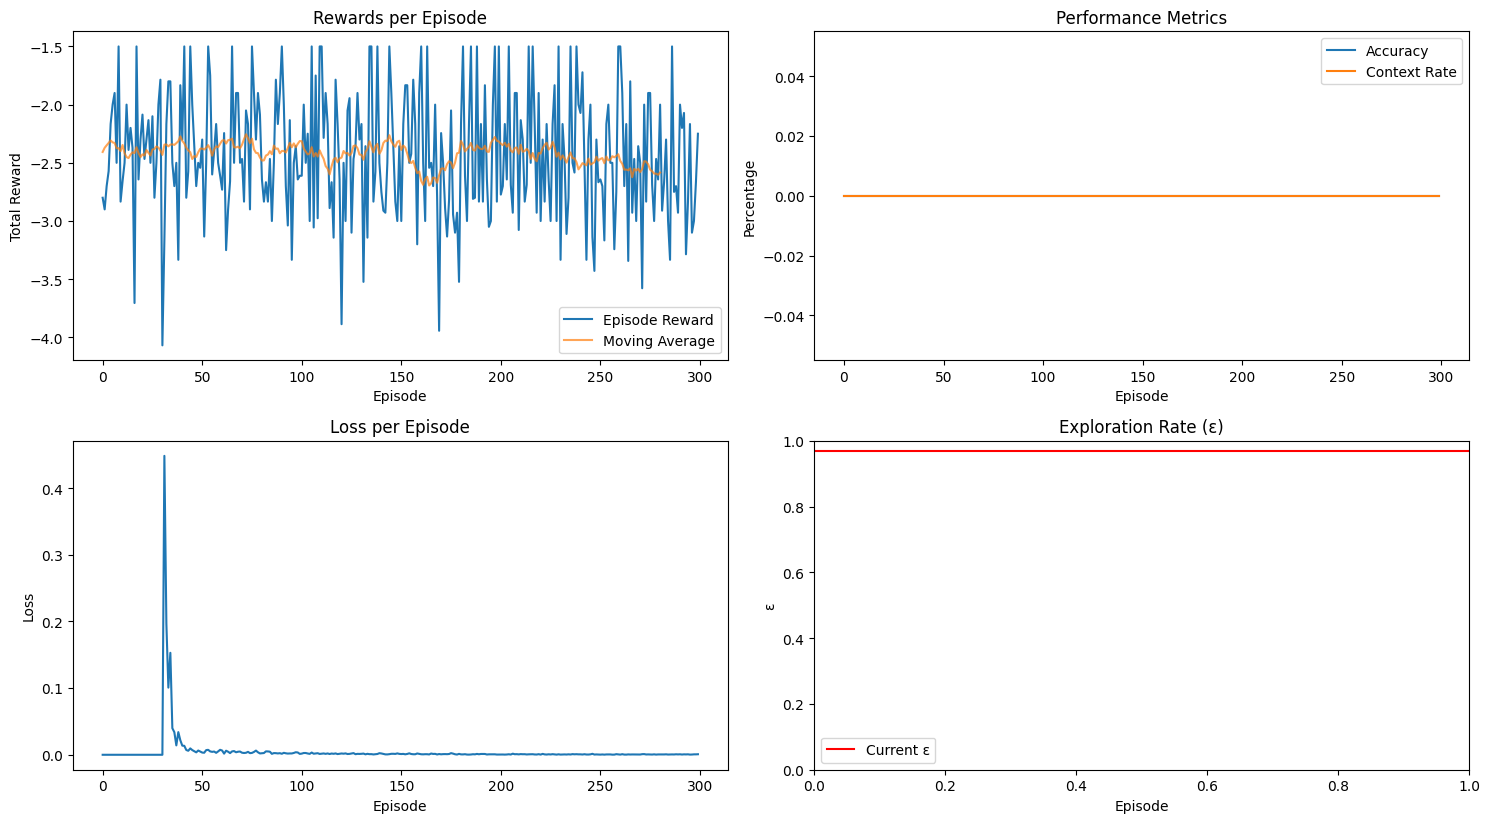

Training Improved DQN:  30%|███       | 302/1000 [01:12<02:30,  4.62it/s, Reward=-1.79, Loss=0.0006, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  30%|███       | 304/1000 [01:12<01:55,  6.01it/s, Reward=-2.80, Loss=0.0007, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  31%|███       | 306/1000 [01:12<01:37,  7.10it/s, Reward=-1.50, Loss=0.0004, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  31%|███       | 308/1000 [01:13<01:28,  7.83it/s, Reward=-3.10, Loss=0.0005, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  31%|███       | 310/1000 [01:13<01:23,  8.22it/s, Reward=-2.20, Loss=0.0009, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  31%|███       | 312/1000 [01:13<01:22,  8.31it/s, Reward=-2.54, Loss=0.0008, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  31%|███▏      | 314/1000 [01:13<01:21,  8.47it/s, Reward=-2.20, Loss=0.0005, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  32%|███▏      | 316/1000 [01:14<01:20,  8.55it/s, Reward=-2.83, Loss=0.0004, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  32%|███▏      | 318/1000 [01:14<01:20,  8.52it/s, Reward=-2.37, Loss=0.0008, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  32%|███▏      | 320/1000 [01:14<01:21,  8.38it/s, Reward=-3.42, Loss=0.0009, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  32%|███▏      | 322/1000 [01:14<01:20,  8.40it/s, Reward=-2.00, Loss=0.0002, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  32%|███▏      | 324/1000 [01:15<01:19,  8.45it/s, Reward=-1.80, Loss=0.0007, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  33%|███▎      | 326/1000 [01:15<01:18,  8.56it/s, Reward=-2.93, Loss=0.0005, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  33%|███▎      | 328/1000 [01:15<01:18,  8.54it/s, Reward=-1.83, Loss=0.0004, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  33%|███▎      | 330/1000 [01:15<01:18,  8.52it/s, Reward=-2.67, Loss=0.0004, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  33%|███▎      | 332/1000 [01:15<01:19,  8.35it/s, Reward=-2.00, Loss=0.0005, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  33%|███▎      | 334/1000 [01:16<01:18,  8.49it/s, Reward=-2.64, Loss=0.0003, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  34%|███▎      | 336/1000 [01:16<01:17,  8.53it/s, Reward=-2.17, Loss=0.0003, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  34%|███▍      | 338/1000 [01:16<01:19,  8.35it/s, Reward=-2.50, Loss=0.0002, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  34%|███▍      | 340/1000 [01:16<01:17,  8.48it/s, Reward=-2.17, Loss=0.0006, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  34%|███▍      | 342/1000 [01:17<01:16,  8.59it/s, Reward=-2.64, Loss=0.0004, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  34%|███▍      | 344/1000 [01:17<01:16,  8.63it/s, Reward=-2.17, Loss=0.0007, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  35%|███▍      | 346/1000 [01:17<01:17,  8.41it/s, Reward=-1.83, Loss=0.0006, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  35%|███▍      | 348/1000 [01:17<01:16,  8.50it/s, Reward=-2.00, Loss=0.0003, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  35%|███▌      | 350/1000 [01:18<01:15,  8.59it/s, Reward=-2.50, Loss=0.0003, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  35%|███▌      | 352/1000 [01:18<01:15,  8.62it/s, Reward=-3.21, Loss=0.0006, Epsilon=0.97, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  35%|███▌      | 354/1000 [01:18<01:16,  8.40it/s, Reward=-2.36, Loss=0.0003, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  36%|███▌      | 356/1000 [01:18<01:18,  8.15it/s, Reward=-2.20, Loss=0.0004, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  36%|███▌      | 358/1000 [01:19<01:25,  7.51it/s, Reward=-2.17, Loss=0.0004, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  36%|███▌      | 360/1000 [01:19<01:21,  7.81it/s, Reward=-2.36, Loss=0.0003, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  36%|███▌      | 362/1000 [01:19<01:21,  7.84it/s, Reward=-2.47, Loss=0.0005, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  36%|███▋      | 364/1000 [01:19<01:19,  8.03it/s, Reward=-1.50, Loss=0.0002, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  37%|███▋      | 366/1000 [01:20<01:22,  7.65it/s, Reward=-2.30, Loss=0.0002, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  37%|███▋      | 368/1000 [01:20<01:19,  7.93it/s, Reward=-2.00, Loss=0.0002, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  37%|███▋      | 370/1000 [01:20<01:22,  7.60it/s, Reward=-1.90, Loss=0.0002, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  37%|███▋      | 372/1000 [01:20<01:24,  7.47it/s, Reward=-3.33, Loss=0.0007, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  37%|███▋      | 374/1000 [01:21<01:21,  7.65it/s, Reward=-2.50, Loss=0.0004, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  38%|███▊      | 376/1000 [01:21<01:18,  7.94it/s, Reward=-1.50, Loss=0.0002, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  38%|███▊      | 378/1000 [01:21<01:21,  7.64it/s, Reward=-3.89, Loss=0.0002, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  38%|███▊      | 380/1000 [01:21<01:24,  7.32it/s, Reward=-1.83, Loss=0.0004, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  38%|███▊      | 382/1000 [01:22<01:24,  7.31it/s, Reward=-3.25, Loss=0.0003, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  38%|███▊      | 384/1000 [01:22<01:25,  7.24it/s, Reward=-1.83, Loss=0.0002, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  39%|███▊      | 386/1000 [01:22<01:21,  7.52it/s, Reward=-1.50, Loss=0.0002, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  39%|███▉      | 388/1000 [01:23<01:19,  7.73it/s, Reward=-2.77, Loss=0.0002, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  39%|███▉      | 390/1000 [01:23<01:17,  7.91it/s, Reward=-2.83, Loss=0.0004, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  39%|███▉      | 392/1000 [01:23<01:18,  7.72it/s, Reward=-2.70, Loss=0.0007, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  39%|███▉      | 394/1000 [01:23<01:20,  7.55it/s, Reward=-2.83, Loss=0.0002, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  40%|███▉      | 396/1000 [01:24<01:14,  8.10it/s, Reward=-2.50, Loss=0.0003, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  40%|███▉      | 398/1000 [01:24<01:12,  8.33it/s, Reward=-2.66, Loss=0.0006, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  40%|███▉      | 399/1000 [01:24<01:13,  8.22it/s, Reward=-1.80, Loss=0.0004, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


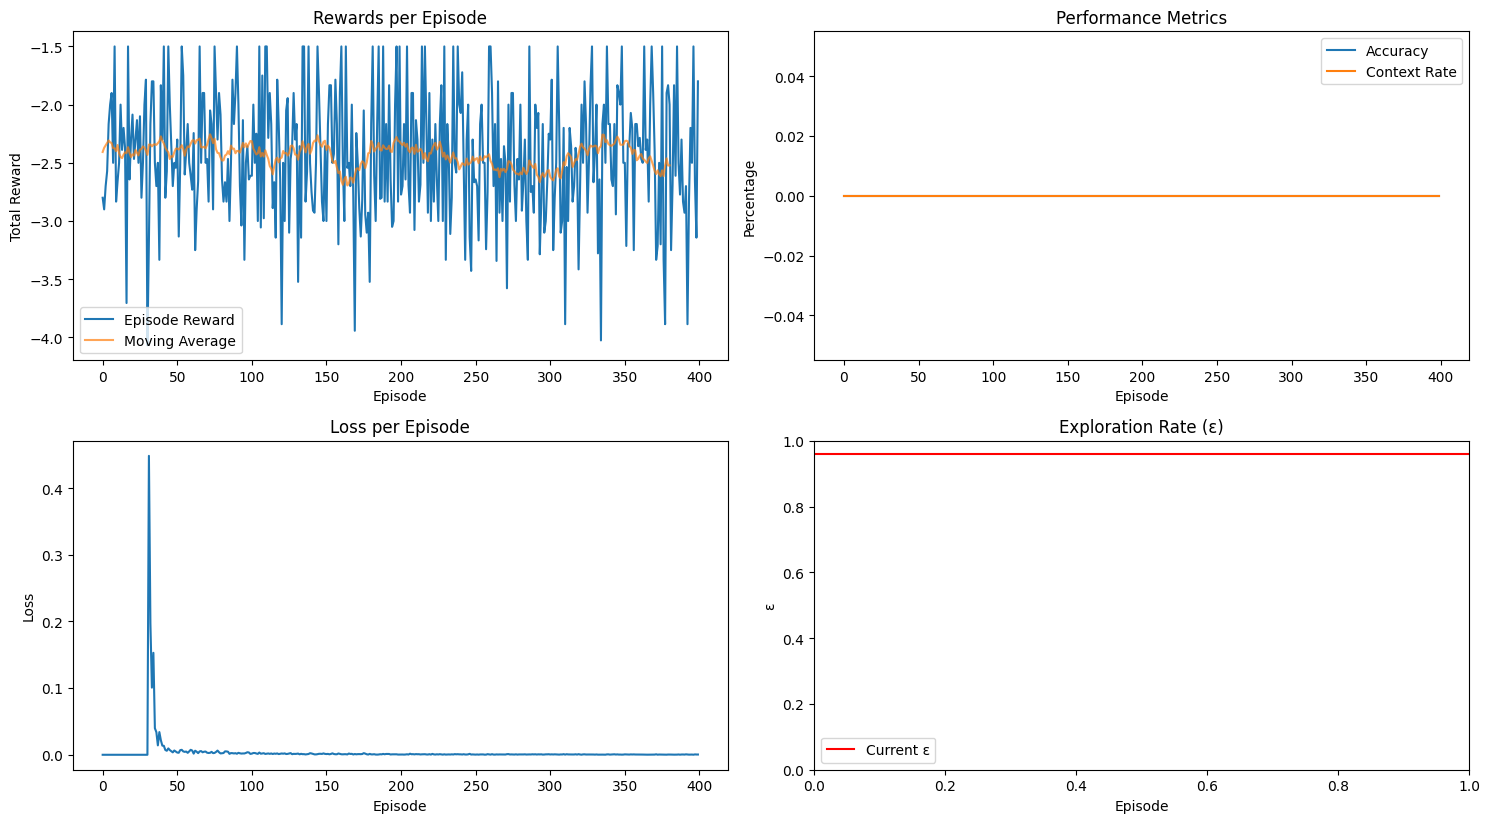

Training Improved DQN:  40%|████      | 402/1000 [01:25<02:50,  3.50it/s, Reward=-3.00, Loss=0.0001, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  40%|████      | 404/1000 [01:26<01:59,  5.00it/s, Reward=-2.70, Loss=0.0003, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  41%|████      | 406/1000 [01:26<01:33,  6.38it/s, Reward=-2.82, Loss=0.0006, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  41%|████      | 408/1000 [01:26<01:23,  7.07it/s, Reward=-2.83, Loss=0.0003, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  41%|████      | 410/1000 [01:26<01:16,  7.76it/s, Reward=-3.52, Loss=0.0006, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  41%|████      | 412/1000 [01:27<01:11,  8.17it/s, Reward=-1.50, Loss=0.0010, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  41%|████▏     | 414/1000 [01:27<01:10,  8.36it/s, Reward=-2.70, Loss=0.0002, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  42%|████▏     | 416/1000 [01:27<01:11,  8.18it/s, Reward=-2.00, Loss=0.0004, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  42%|████▏     | 418/1000 [01:27<01:09,  8.35it/s, Reward=-2.67, Loss=0.0002, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  42%|████▏     | 420/1000 [01:28<01:08,  8.44it/s, Reward=-3.00, Loss=0.0002, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  42%|████▏     | 422/1000 [01:28<01:07,  8.52it/s, Reward=-2.00, Loss=0.0001, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  42%|████▏     | 424/1000 [01:28<01:07,  8.53it/s, Reward=-2.36, Loss=0.0003, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  43%|████▎     | 426/1000 [01:28<01:07,  8.51it/s, Reward=-3.10, Loss=0.0005, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  43%|████▎     | 428/1000 [01:28<01:06,  8.56it/s, Reward=-2.48, Loss=0.0005, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  43%|████▎     | 430/1000 [01:29<01:07,  8.45it/s, Reward=-1.50, Loss=0.0003, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  43%|████▎     | 432/1000 [01:29<01:06,  8.50it/s, Reward=-2.55, Loss=0.0004, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  43%|████▎     | 434/1000 [01:29<01:09,  8.09it/s, Reward=-2.62, Loss=0.0007, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  44%|████▎     | 436/1000 [01:29<01:13,  7.69it/s, Reward=-2.00, Loss=0.0007, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  44%|████▍     | 438/1000 [01:30<01:09,  8.10it/s, Reward=-3.00, Loss=0.0004, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  44%|████▍     | 440/1000 [01:30<01:07,  8.31it/s, Reward=-2.50, Loss=0.0003, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  44%|████▍     | 442/1000 [01:30<01:08,  8.20it/s, Reward=-1.79, Loss=0.0003, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  44%|████▍     | 444/1000 [01:30<01:07,  8.29it/s, Reward=-2.30, Loss=0.0003, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  44%|████▍     | 445/1000 [01:31<01:19,  6.96it/s, Reward=-3.33, Loss=0.0002, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  45%|████▍     | 448/1000 [01:31<01:31,  6.02it/s, Reward=-2.83, Loss=0.0002, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  45%|████▌     | 450/1000 [01:31<01:26,  6.39it/s, Reward=-1.80, Loss=0.0004, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  45%|████▌     | 452/1000 [01:32<01:22,  6.61it/s, Reward=-2.50, Loss=0.0003, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  45%|████▌     | 454/1000 [01:32<01:20,  6.79it/s, Reward=-2.60, Loss=0.0003, Epsilon=0.96, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  46%|████▌     | 456/1000 [01:32<01:23,  6.50it/s, Reward=-2.93, Loss=0.0004, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  46%|████▌     | 458/1000 [01:33<01:19,  6.79it/s, Reward=-2.30, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  46%|████▌     | 460/1000 [01:33<01:16,  7.08it/s, Reward=-2.00, Loss=0.0003, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  46%|████▌     | 462/1000 [01:33<01:27,  6.17it/s, Reward=-2.91, Loss=0.0003, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  46%|████▋     | 463/1000 [01:33<01:36,  5.58it/s, Reward=-2.47, Loss=0.0001, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  46%|████▋     | 464/1000 [01:34<01:41,  5.29it/s, Reward=-1.90, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  46%|████▋     | 465/1000 [01:34<01:45,  5.08it/s, Reward=-2.30, Loss=0.0004, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  47%|████▋     | 466/1000 [01:34<01:48,  4.91it/s, Reward=-2.50, Loss=0.0004, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  47%|████▋     | 468/1000 [01:35<01:50,  4.82it/s, Reward=-2.30, Loss=0.0004, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  47%|████▋     | 470/1000 [01:35<01:44,  5.07it/s, Reward=-2.75, Loss=0.0001, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  47%|████▋     | 472/1000 [01:35<01:39,  5.30it/s, Reward=-1.50, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  47%|████▋     | 473/1000 [01:36<01:42,  5.13it/s, Reward=-1.79, Loss=0.0001, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  48%|████▊     | 476/1000 [01:36<01:40,  5.19it/s, Reward=-2.50, Loss=0.0001, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  48%|████▊     | 478/1000 [01:36<01:39,  5.24it/s, Reward=-2.83, Loss=0.0003, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  48%|████▊     | 480/1000 [01:37<01:32,  5.63it/s, Reward=-2.75, Loss=0.0001, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  48%|████▊     | 481/1000 [01:37<01:34,  5.47it/s, Reward=-2.09, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  48%|████▊     | 482/1000 [01:37<01:39,  5.22it/s, Reward=-2.50, Loss=0.0004, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  48%|████▊     | 483/1000 [01:37<01:42,  5.06it/s, Reward=-2.07, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  48%|████▊     | 484/1000 [01:38<01:46,  4.86it/s, Reward=-1.94, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  48%|████▊     | 485/1000 [01:38<01:47,  4.78it/s, Reward=-3.13, Loss=0.0004, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  49%|████▊     | 487/1000 [01:38<01:45,  4.86it/s, Reward=-2.30, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  49%|████▉     | 488/1000 [01:39<01:46,  4.82it/s, Reward=-2.13, Loss=0.0001, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  49%|████▉     | 489/1000 [01:39<01:48,  4.72it/s, Reward=-2.30, Loss=0.0001, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  49%|████▉     | 490/1000 [01:39<01:46,  4.80it/s, Reward=-1.90, Loss=0.0003, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  49%|████▉     | 491/1000 [01:39<01:46,  4.76it/s, Reward=-2.37, Loss=0.0004, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  49%|████▉     | 493/1000 [01:40<01:43,  4.88it/s, Reward=-3.00, Loss=0.0003, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  50%|████▉     | 495/1000 [01:40<01:40,  5.02it/s, Reward=-2.24, Loss=0.0003, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  50%|████▉     | 496/1000 [01:40<01:43,  4.86it/s, Reward=-2.17, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  50%|████▉     | 498/1000 [01:41<01:41,  4.95it/s, Reward=-2.50, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  50%|████▉     | 499/1000 [01:41<01:36,  5.22it/s, Reward=-2.48, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


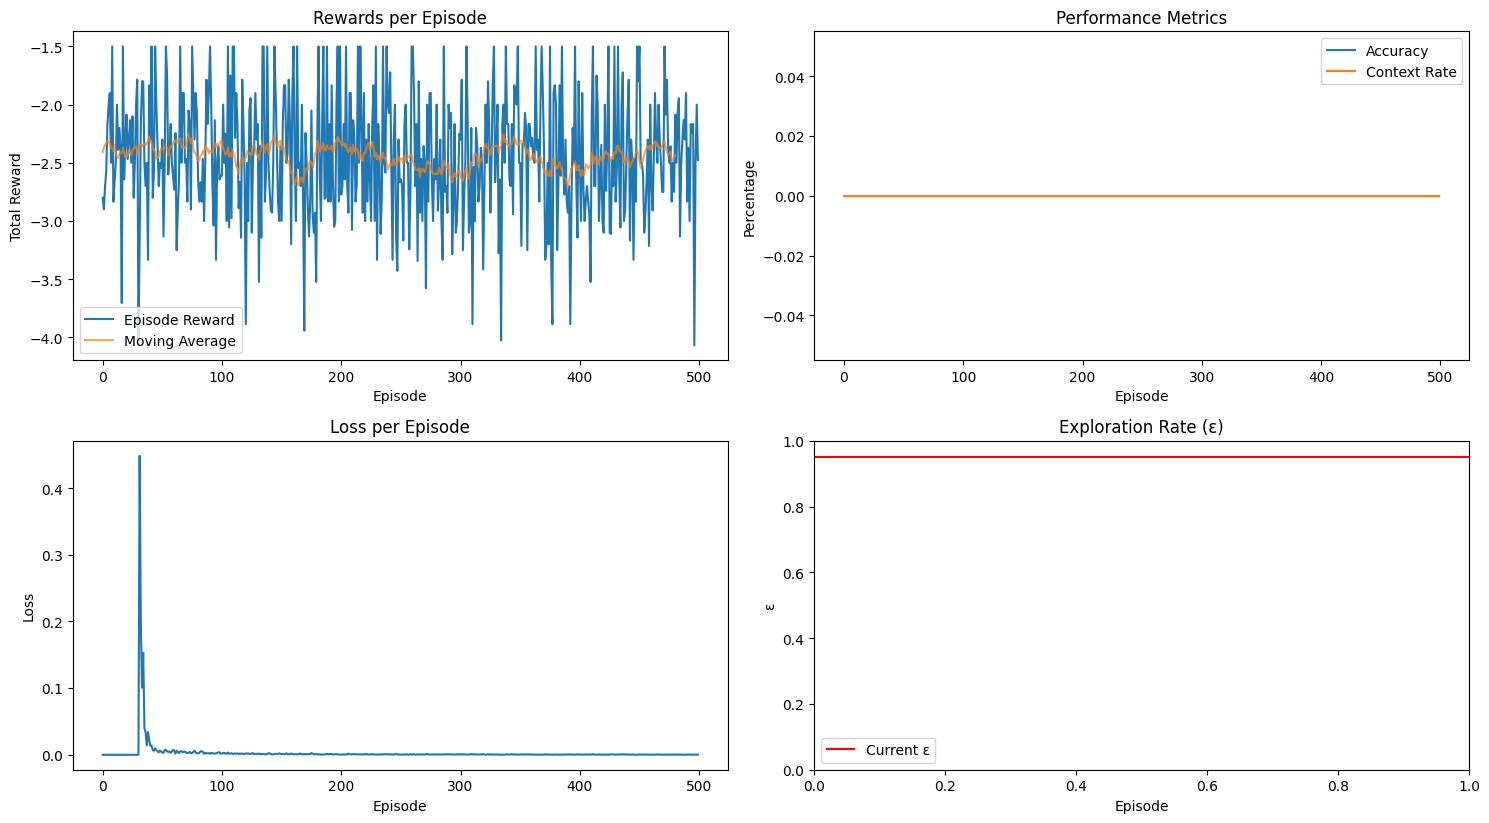

Training Improved DQN:  50%|█████     | 502/1000 [01:42<02:46,  2.99it/s, Reward=-2.94, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  50%|█████     | 504/1000 [01:43<02:04,  3.98it/s, Reward=-2.93, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  51%|█████     | 506/1000 [01:43<01:37,  5.05it/s, Reward=-2.47, Loss=0.0004, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  51%|█████     | 507/1000 [01:43<01:35,  5.17it/s, Reward=-2.83, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  51%|█████     | 510/1000 [01:44<01:29,  5.46it/s, Reward=-2.75, Loss=0.0003, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  51%|█████     | 512/1000 [01:44<01:25,  5.72it/s, Reward=-1.90, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  51%|█████▏    | 514/1000 [01:44<01:18,  6.21it/s, Reward=-3.10, Loss=0.0004, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  52%|█████▏    | 515/1000 [01:45<01:39,  4.87it/s, Reward=-2.17, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0


Training Improved DQN:  52%|█████▏    | 517/1000 [01:45<01:29,  5.38it/s, Reward=-2.00, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  52%|█████▏    | 519/1000 [01:45<01:13,  6.53it/s, Reward=-2.17, Loss=0.0001, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  52%|█████▏    | 521/1000 [01:45<01:05,  7.37it/s, Reward=-2.80, Loss=0.0001, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  52%|█████▏    | 523/1000 [01:46<01:01,  7.75it/s, Reward=-2.20, Loss=0.0001, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  52%|█████▎    | 525/1000 [01:46<00:59,  8.04it/s, Reward=-1.79, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  53%|█████▎    | 527/1000 [01:46<00:59,  8.00it/s, Reward=-2.70, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  53%|█████▎    | 529/1000 [01:46<00:57,  8.15it/s, Reward=-2.00, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  53%|█████▎    | 531/1000 [01:47<00:57,  8.17it/s, Reward=-2.90, Loss=0.0004, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  53%|█████▎    | 533/1000 [01:47<00:55,  8.34it/s, Reward=-3.21, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  54%|█████▎    | 535/1000 [01:47<00:57,  8.02it/s, Reward=-2.81, Loss=0.0003, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  54%|█████▎    | 537/1000 [01:47<00:56,  8.23it/s, Reward=-1.90, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  54%|█████▍    | 539/1000 [01:48<00:55,  8.32it/s, Reward=-3.06, Loss=0.0003, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  54%|█████▍    | 541/1000 [01:48<00:55,  8.28it/s, Reward=-3.21, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  54%|█████▍    | 543/1000 [01:48<00:55,  8.18it/s, Reward=-1.80, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  55%|█████▍    | 545/1000 [01:48<00:54,  8.31it/s, Reward=-2.25, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  55%|█████▍    | 547/1000 [01:49<00:54,  8.31it/s, Reward=-2.57, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  55%|█████▍    | 549/1000 [01:49<00:54,  8.32it/s, Reward=-2.34, Loss=0.0004, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  55%|█████▌    | 551/1000 [01:49<00:56,  7.97it/s, Reward=-2.50, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  55%|█████▌    | 553/1000 [01:49<00:55,  8.09it/s, Reward=-2.93, Loss=0.0003, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  56%|█████▌    | 555/1000 [01:50<00:54,  8.13it/s, Reward=-3.21, Loss=0.0002, Epsilon=0.95, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  56%|█████▌    | 557/1000 [01:50<00:53,  8.24it/s, Reward=-2.20, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  56%|█████▌    | 559/1000 [01:50<00:54,  8.16it/s, Reward=-1.50, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  56%|█████▌    | 561/1000 [01:50<00:53,  8.22it/s, Reward=-2.00, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  56%|█████▋    | 563/1000 [01:51<00:56,  7.74it/s, Reward=-2.65, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  56%|█████▋    | 565/1000 [01:51<00:56,  7.71it/s, Reward=-2.50, Loss=0.0003, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  57%|█████▋    | 567/1000 [01:51<00:57,  7.53it/s, Reward=-2.66, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  57%|█████▋    | 569/1000 [01:51<00:57,  7.45it/s, Reward=-2.91, Loss=0.0004, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  57%|█████▋    | 571/1000 [01:52<00:56,  7.54it/s, Reward=-2.50, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  57%|█████▋    | 573/1000 [01:52<00:55,  7.70it/s, Reward=-2.64, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  57%|█████▊    | 575/1000 [01:52<00:57,  7.41it/s, Reward=-2.88, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  58%|█████▊    | 577/1000 [01:53<00:56,  7.46it/s, Reward=-2.30, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  58%|█████▊    | 579/1000 [01:53<00:56,  7.43it/s, Reward=-2.17, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  58%|█████▊    | 581/1000 [01:53<01:01,  6.84it/s, Reward=-2.30, Loss=0.0003, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  58%|█████▊    | 583/1000 [01:53<00:57,  7.26it/s, Reward=-3.00, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  58%|█████▊    | 585/1000 [01:54<00:59,  6.99it/s, Reward=-3.33, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  59%|█████▊    | 587/1000 [01:54<00:59,  6.96it/s, Reward=-2.93, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  59%|█████▉    | 589/1000 [01:54<01:01,  6.73it/s, Reward=-2.07, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  59%|█████▉    | 591/1000 [01:55<01:01,  6.68it/s, Reward=-3.00, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  59%|█████▉    | 593/1000 [01:55<01:00,  6.72it/s, Reward=-2.70, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  60%|█████▉    | 595/1000 [01:55<01:02,  6.51it/s, Reward=-2.89, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  60%|█████▉    | 597/1000 [01:55<01:00,  6.68it/s, Reward=-2.83, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  60%|█████▉    | 599/1000 [01:56<00:59,  6.76it/s, Reward=-2.30, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  60%|█████▉    | 599/1000 [01:56<00:59,  6.76it/s, Reward=-2.17, Loss=0.0003, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0


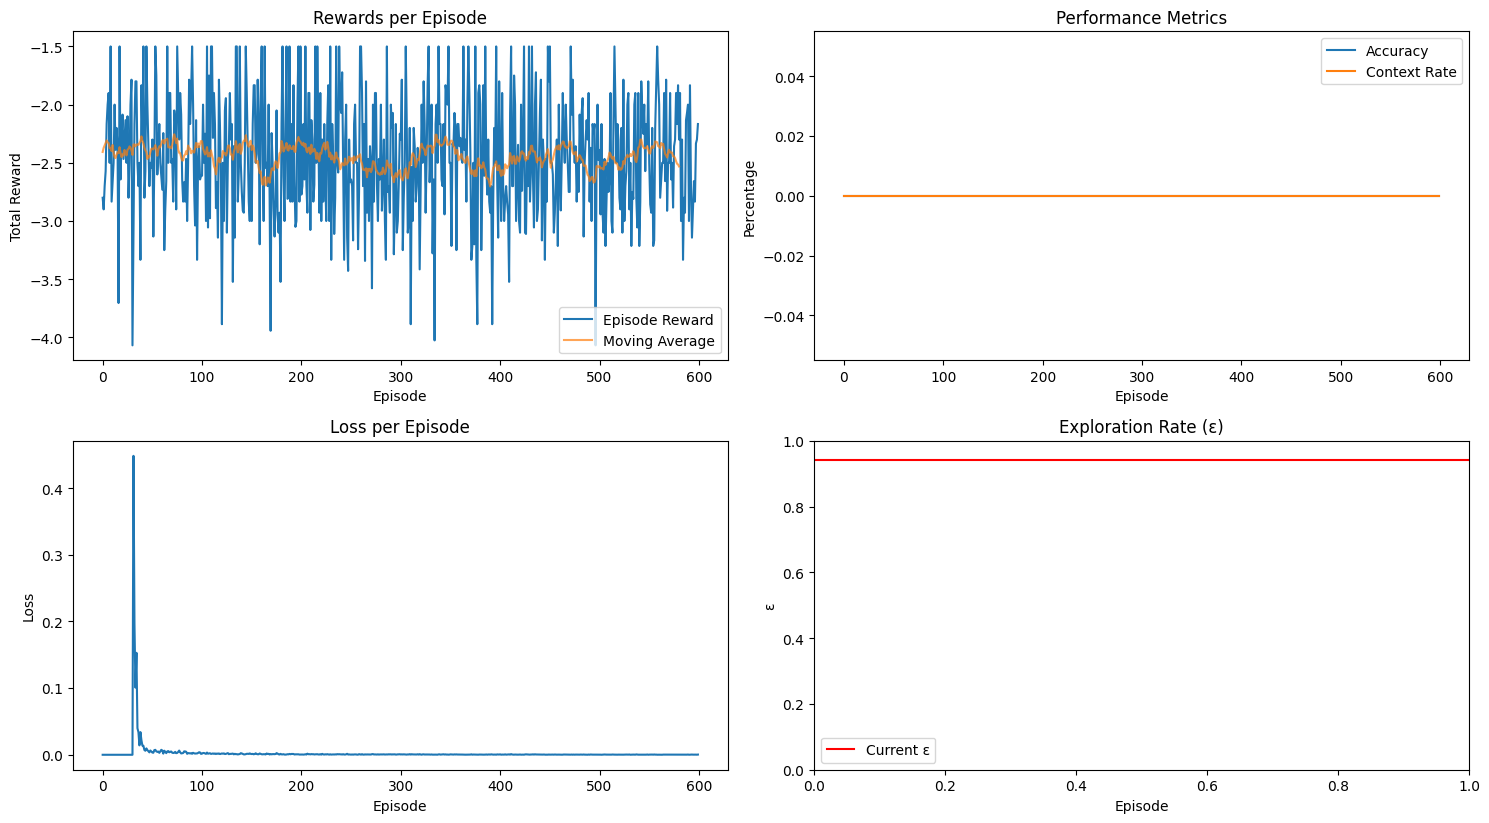

Training Improved DQN:  60%|██████    | 602/1000 [01:57<01:58,  3.37it/s, Reward=-2.30, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  60%|██████    | 604/1000 [01:57<01:22,  4.81it/s, Reward=-2.70, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  61%|██████    | 606/1000 [01:58<01:05,  5.99it/s, Reward=-2.77, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  61%|██████    | 608/1000 [01:58<00:56,  6.88it/s, Reward=-2.75, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  61%|██████    | 610/1000 [01:58<00:53,  7.25it/s, Reward=-1.50, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  61%|██████    | 612/1000 [01:58<00:50,  7.70it/s, Reward=-2.50, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  61%|██████▏   | 614/1000 [01:59<00:50,  7.67it/s, Reward=-2.70, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  62%|██████▏   | 616/1000 [01:59<00:48,  7.95it/s, Reward=-2.50, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  62%|██████▏   | 618/1000 [01:59<00:47,  8.01it/s, Reward=-2.50, Loss=0.0000, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  62%|██████▏   | 620/1000 [01:59<00:46,  8.09it/s, Reward=-2.00, Loss=0.0003, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  62%|██████▏   | 622/1000 [02:00<00:46,  8.16it/s, Reward=-2.50, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  62%|██████▏   | 624/1000 [02:00<00:46,  8.15it/s, Reward=-2.47, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  63%|██████▎   | 626/1000 [02:00<00:46,  8.01it/s, Reward=-2.00, Loss=0.0003, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  63%|██████▎   | 628/1000 [02:00<00:45,  8.12it/s, Reward=-3.21, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  63%|██████▎   | 630/1000 [02:01<00:45,  8.05it/s, Reward=-1.80, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  63%|██████▎   | 632/1000 [02:01<00:46,  7.92it/s, Reward=-1.50, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  63%|██████▎   | 634/1000 [02:01<00:46,  7.90it/s, Reward=-3.20, Loss=0.0003, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  64%|██████▎   | 636/1000 [02:01<00:45,  8.04it/s, Reward=-1.50, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  64%|██████▍   | 638/1000 [02:02<00:44,  8.06it/s, Reward=-2.83, Loss=0.0004, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  64%|██████▍   | 640/1000 [02:02<00:45,  7.97it/s, Reward=-2.50, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  64%|██████▍   | 642/1000 [02:02<00:44,  7.98it/s, Reward=-2.83, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  64%|██████▍   | 644/1000 [02:02<00:44,  8.01it/s, Reward=-2.37, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  65%|██████▍   | 646/1000 [02:03<00:44,  7.98it/s, Reward=-3.25, Loss=0.0004, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  65%|██████▍   | 648/1000 [02:03<00:45,  7.78it/s, Reward=-3.14, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  65%|██████▌   | 650/1000 [02:03<00:45,  7.71it/s, Reward=-1.90, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  65%|██████▌   | 652/1000 [02:04<00:43,  7.96it/s, Reward=-1.50, Loss=0.0003, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  65%|██████▌   | 654/1000 [02:04<00:42,  8.08it/s, Reward=-2.00, Loss=0.0001, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  66%|██████▌   | 656/1000 [02:04<00:42,  8.06it/s, Reward=-2.94, Loss=0.0002, Epsilon=0.94, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  66%|██████▌   | 658/1000 [02:04<00:42,  8.05it/s, Reward=-1.50, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  66%|██████▌   | 660/1000 [02:04<00:41,  8.11it/s, Reward=-2.94, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  66%|██████▌   | 662/1000 [02:05<00:41,  8.19it/s, Reward=-2.00, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  66%|██████▋   | 664/1000 [02:05<00:42,  7.90it/s, Reward=-3.10, Loss=0.0003, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  67%|██████▋   | 666/1000 [02:05<00:42,  7.81it/s, Reward=-1.79, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  67%|██████▋   | 668/1000 [02:06<00:42,  7.86it/s, Reward=-1.83, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  67%|██████▋   | 670/1000 [02:06<00:41,  8.01it/s, Reward=-2.64, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  67%|██████▋   | 672/1000 [02:06<00:41,  7.94it/s, Reward=-2.80, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  67%|██████▋   | 674/1000 [02:06<00:41,  7.93it/s, Reward=-2.41, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  68%|██████▊   | 676/1000 [02:07<00:40,  7.96it/s, Reward=-2.70, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  68%|██████▊   | 678/1000 [02:07<00:40,  7.86it/s, Reward=-2.55, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  68%|██████▊   | 680/1000 [02:07<00:46,  6.93it/s, Reward=-2.47, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  68%|██████▊   | 682/1000 [02:07<00:46,  6.90it/s, Reward=-1.50, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  68%|██████▊   | 684/1000 [02:08<00:44,  7.08it/s, Reward=-3.13, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  69%|██████▊   | 686/1000 [02:08<00:42,  7.38it/s, Reward=-2.13, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  69%|██████▉   | 688/1000 [02:08<00:45,  6.91it/s, Reward=-2.93, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  69%|██████▉   | 690/1000 [02:08<00:42,  7.23it/s, Reward=-3.10, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  69%|██████▉   | 692/1000 [02:09<00:40,  7.65it/s, Reward=-3.47, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  69%|██████▉   | 694/1000 [02:09<00:38,  7.90it/s, Reward=-1.80, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  70%|██████▉   | 696/1000 [02:09<00:43,  7.06it/s, Reward=-2.70, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  70%|██████▉   | 698/1000 [02:10<00:44,  6.75it/s, Reward=-1.79, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  70%|██████▉   | 699/1000 [02:10<00:44,  6.84it/s, Reward=-2.23, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


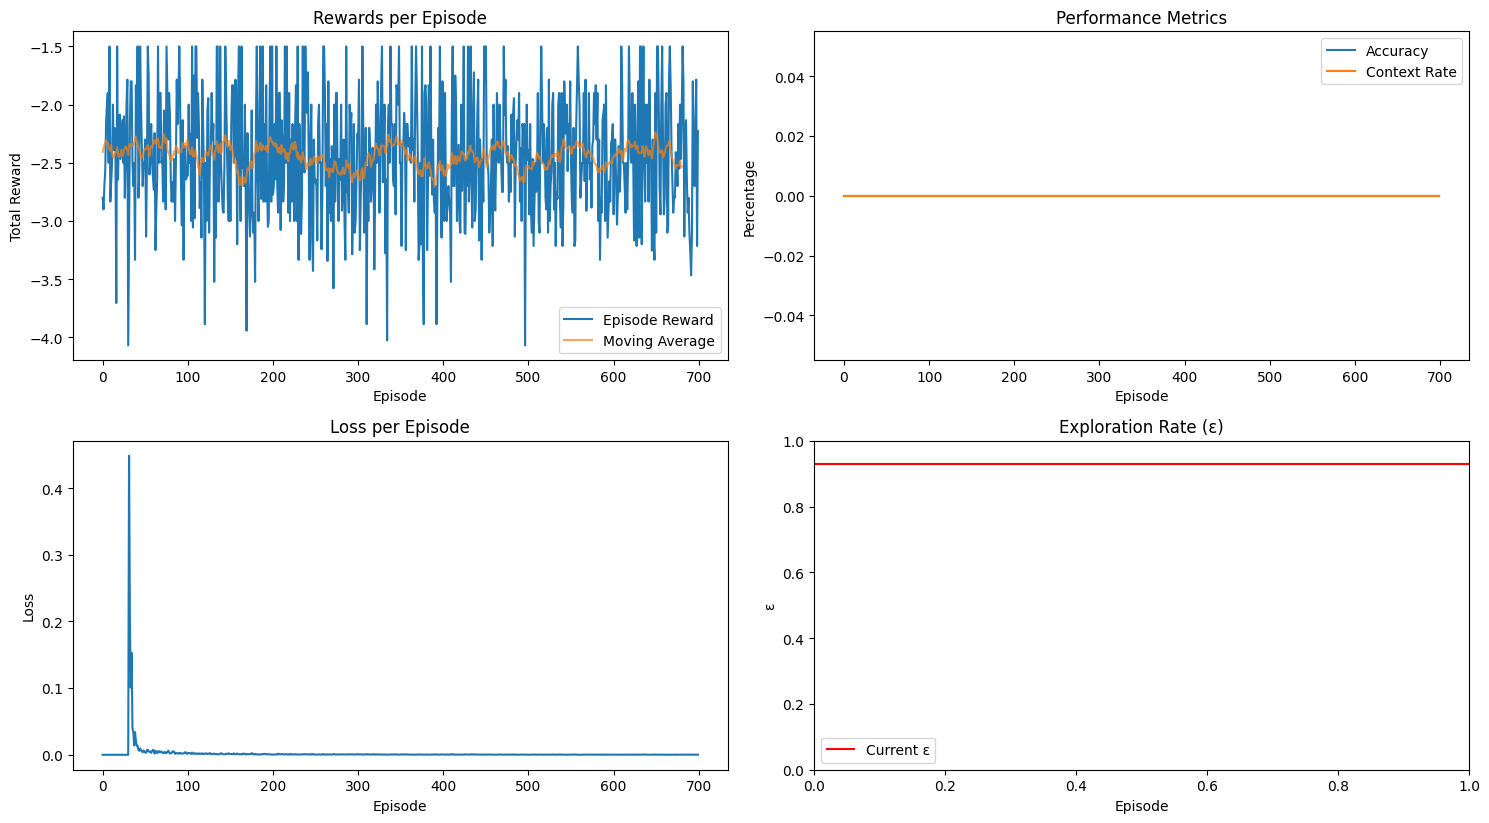

Training Improved DQN:  70%|███████   | 702/1000 [02:11<01:28,  3.39it/s, Reward=-3.00, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  70%|███████   | 704/1000 [02:12<01:05,  4.49it/s, Reward=-2.83, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  71%|███████   | 706/1000 [02:12<00:53,  5.45it/s, Reward=-1.90, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  71%|███████   | 708/1000 [02:12<00:50,  5.82it/s, Reward=-1.83, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  71%|███████   | 710/1000 [02:12<00:44,  6.55it/s, Reward=-2.83, Loss=0.0003, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  71%|███████   | 712/1000 [02:13<00:41,  6.96it/s, Reward=-3.56, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  71%|███████▏  | 714/1000 [02:13<00:38,  7.35it/s, Reward=-1.80, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  72%|███████▏  | 716/1000 [02:13<00:41,  6.90it/s, Reward=-2.17, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  72%|███████▏  | 718/1000 [02:14<00:38,  7.26it/s, Reward=-2.61, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  72%|███████▏  | 720/1000 [02:14<00:40,  6.98it/s, Reward=-2.07, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  72%|███████▏  | 722/1000 [02:14<00:40,  6.90it/s, Reward=-2.64, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  72%|███████▏  | 724/1000 [02:14<00:36,  7.53it/s, Reward=-1.50, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  73%|███████▎  | 726/1000 [02:15<00:35,  7.78it/s, Reward=-2.36, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  73%|███████▎  | 728/1000 [02:15<00:34,  7.96it/s, Reward=-3.10, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  73%|███████▎  | 730/1000 [02:15<00:34,  7.82it/s, Reward=-3.00, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  73%|███████▎  | 732/1000 [02:15<00:33,  7.98it/s, Reward=-2.00, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  73%|███████▎  | 734/1000 [02:16<00:33,  8.00it/s, Reward=-3.10, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  74%|███████▎  | 736/1000 [02:16<00:33,  7.89it/s, Reward=-2.30, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  74%|███████▍  | 738/1000 [02:16<00:33,  7.80it/s, Reward=-2.30, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  74%|███████▍  | 740/1000 [02:16<00:32,  7.95it/s, Reward=-2.70, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  74%|███████▍  | 742/1000 [02:17<00:32,  8.00it/s, Reward=-2.17, Loss=0.0002, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  74%|███████▍  | 744/1000 [02:17<00:32,  7.92it/s, Reward=-3.00, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  75%|███████▍  | 746/1000 [02:17<00:32,  7.84it/s, Reward=-2.64, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  75%|███████▍  | 748/1000 [02:17<00:31,  8.05it/s, Reward=-2.81, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  75%|███████▌  | 750/1000 [02:18<00:31,  8.05it/s, Reward=-2.40, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  75%|███████▌  | 752/1000 [02:18<00:30,  8.03it/s, Reward=-3.89, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  75%|███████▌  | 754/1000 [02:18<00:30,  7.97it/s, Reward=-2.98, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  76%|███████▌  | 756/1000 [02:18<00:29,  8.14it/s, Reward=-2.83, Loss=0.0001, Epsilon=0.93, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  76%|███████▌  | 758/1000 [02:19<00:29,  8.11it/s, Reward=-3.06, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  76%|███████▌  | 760/1000 [02:19<00:30,  7.99it/s, Reward=-1.50, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  76%|███████▌  | 762/1000 [02:19<00:30,  7.87it/s, Reward=-2.94, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  76%|███████▋  | 764/1000 [02:19<00:29,  8.01it/s, Reward=-1.79, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  77%|███████▋  | 766/1000 [02:20<00:29,  8.05it/s, Reward=-1.50, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  77%|███████▋  | 768/1000 [02:20<00:29,  7.95it/s, Reward=-3.67, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  77%|███████▋  | 770/1000 [02:20<00:29,  7.79it/s, Reward=-2.20, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  77%|███████▋  | 772/1000 [02:20<00:28,  7.95it/s, Reward=-2.20, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  77%|███████▋  | 774/1000 [02:21<00:28,  8.03it/s, Reward=-2.00, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  78%|███████▊  | 776/1000 [02:21<00:27,  8.02it/s, Reward=-1.83, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  78%|███████▊  | 778/1000 [02:21<00:27,  7.99it/s, Reward=-3.28, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  78%|███████▊  | 780/1000 [02:21<00:27,  8.04it/s, Reward=-2.94, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  78%|███████▊  | 782/1000 [02:22<00:27,  7.93it/s, Reward=-1.50, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  78%|███████▊  | 784/1000 [02:22<00:27,  8.00it/s, Reward=-2.55, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  79%|███████▊  | 786/1000 [02:22<00:27,  7.76it/s, Reward=-2.09, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  79%|███████▉  | 788/1000 [02:22<00:26,  7.92it/s, Reward=-2.05, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  79%|███████▉  | 790/1000 [02:23<00:26,  7.99it/s, Reward=-3.20, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  79%|███████▉  | 792/1000 [02:23<00:25,  8.07it/s, Reward=-2.00, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  79%|███████▉  | 794/1000 [02:23<00:26,  7.76it/s, Reward=-2.30, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  80%|███████▉  | 796/1000 [02:23<00:25,  7.90it/s, Reward=-2.50, Loss=0.0003, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  80%|███████▉  | 798/1000 [02:24<00:25,  7.98it/s, Reward=-1.50, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  80%|███████▉  | 799/1000 [02:24<00:25,  7.87it/s, Reward=-2.61, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


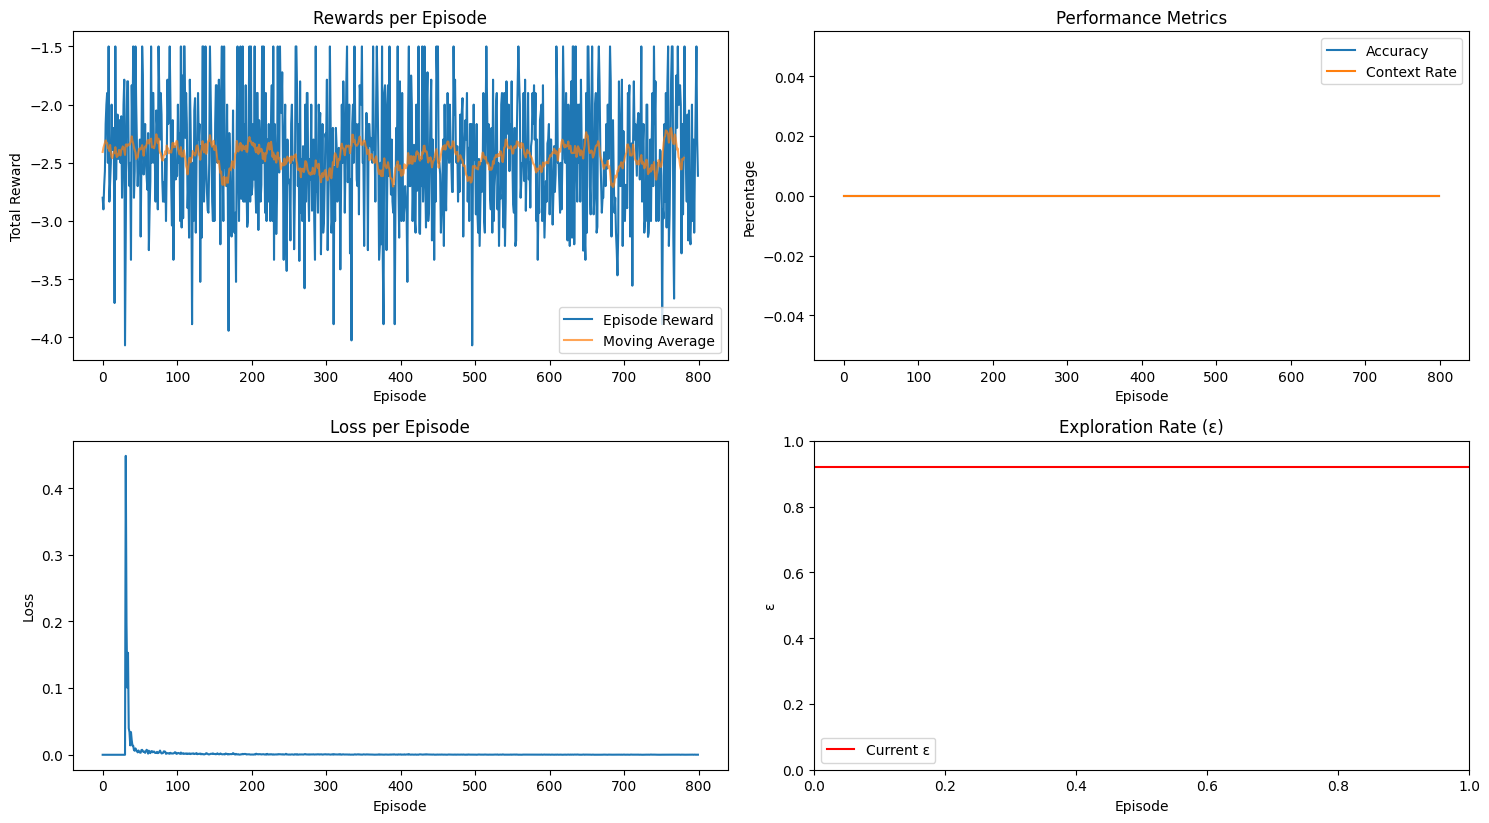

Training Improved DQN:  80%|████████  | 802/1000 [02:25<00:58,  3.36it/s, Reward=-3.00, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  80%|████████  | 804/1000 [02:26<00:43,  4.55it/s, Reward=-2.00, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  81%|████████  | 806/1000 [02:26<00:35,  5.53it/s, Reward=-3.32, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  81%|████████  | 808/1000 [02:26<00:31,  6.18it/s, Reward=-2.17, Loss=0.0003, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  81%|████████  | 810/1000 [02:26<00:28,  6.68it/s, Reward=-2.70, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  81%|████████  | 812/1000 [02:27<00:26,  7.22it/s, Reward=-3.10, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  81%|████████▏ | 814/1000 [02:27<00:24,  7.74it/s, Reward=-2.50, Loss=0.0003, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  82%|████████▏ | 816/1000 [02:27<00:24,  7.39it/s, Reward=-2.30, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  82%|████████▏ | 818/1000 [02:27<00:24,  7.55it/s, Reward=-1.50, Loss=0.0003, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  82%|████████▏ | 820/1000 [02:28<00:22,  7.90it/s, Reward=-2.83, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  82%|████████▏ | 822/1000 [02:28<00:21,  8.12it/s, Reward=-3.00, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  82%|████████▏ | 824/1000 [02:28<00:24,  7.24it/s, Reward=-1.50, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  83%|████████▎ | 826/1000 [02:29<00:24,  7.02it/s, Reward=-2.00, Loss=0.0000, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  83%|████████▎ | 828/1000 [02:29<00:24,  6.91it/s, Reward=-1.50, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  83%|████████▎ | 830/1000 [02:29<00:26,  6.51it/s, Reward=-2.50, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  83%|████████▎ | 832/1000 [02:29<00:25,  6.56it/s, Reward=-3.06, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  83%|████████▎ | 834/1000 [02:30<00:25,  6.61it/s, Reward=-2.93, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  84%|████████▎ | 836/1000 [02:30<00:25,  6.48it/s, Reward=-1.50, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  84%|████████▍ | 838/1000 [02:30<00:23,  6.92it/s, Reward=-2.25, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  84%|████████▍ | 840/1000 [02:31<00:22,  7.02it/s, Reward=-2.30, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  84%|████████▍ | 842/1000 [02:31<00:21,  7.45it/s, Reward=-2.66, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  84%|████████▍ | 844/1000 [02:31<00:21,  7.31it/s, Reward=-1.79, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  85%|████████▍ | 846/1000 [02:31<00:21,  7.23it/s, Reward=-2.30, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  85%|████████▍ | 848/1000 [02:32<00:21,  6.97it/s, Reward=-3.47, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  85%|████████▌ | 850/1000 [02:32<00:19,  7.52it/s, Reward=-1.50, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  85%|████████▌ | 852/1000 [02:32<00:19,  7.73it/s, Reward=-1.50, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  85%|████████▌ | 854/1000 [02:32<00:18,  7.95it/s, Reward=-2.09, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  86%|████████▌ | 856/1000 [02:33<00:18,  7.96it/s, Reward=-3.56, Loss=0.0001, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  86%|████████▌ | 858/1000 [02:33<00:17,  8.04it/s, Reward=-1.80, Loss=0.0002, Epsilon=0.92, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  86%|████████▌ | 860/1000 [02:33<00:17,  7.81it/s, Reward=-2.07, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  86%|████████▌ | 862/1000 [02:33<00:17,  7.96it/s, Reward=-2.50, Loss=0.0002, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  86%|████████▋ | 864/1000 [02:34<00:16,  8.01it/s, Reward=-2.50, Loss=0.0003, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  87%|████████▋ | 866/1000 [02:34<00:16,  8.01it/s, Reward=-3.19, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  87%|████████▋ | 868/1000 [02:34<00:16,  7.99it/s, Reward=-2.44, Loss=0.0002, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  87%|████████▋ | 870/1000 [02:34<00:16,  8.05it/s, Reward=-2.83, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  87%|████████▋ | 872/1000 [02:35<00:16,  7.86it/s, Reward=-3.07, Loss=0.0000, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  87%|████████▋ | 874/1000 [02:35<00:15,  8.05it/s, Reward=-3.34, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  88%|████████▊ | 876/1000 [02:35<00:15,  7.79it/s, Reward=-3.10, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  88%|████████▊ | 878/1000 [02:35<00:15,  7.90it/s, Reward=-1.94, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  88%|████████▊ | 880/1000 [02:36<00:15,  7.91it/s, Reward=-2.07, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  88%|████████▊ | 882/1000 [02:36<00:14,  8.02it/s, Reward=-2.00, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  88%|████████▊ | 884/1000 [02:36<00:14,  8.05it/s, Reward=-1.83, Loss=0.0002, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  89%|████████▊ | 886/1000 [02:36<00:14,  7.98it/s, Reward=-2.00, Loss=0.0002, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  89%|████████▉ | 888/1000 [02:37<00:13,  8.05it/s, Reward=-2.47, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  89%|████████▉ | 890/1000 [02:37<00:13,  8.06it/s, Reward=-2.50, Loss=0.0002, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  89%|████████▉ | 892/1000 [02:37<00:13,  8.00it/s, Reward=-2.50, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  89%|████████▉ | 894/1000 [02:37<00:13,  7.98it/s, Reward=-2.50, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  90%|████████▉ | 896/1000 [02:38<00:12,  8.00it/s, Reward=-2.17, Loss=0.0000, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  90%|████████▉ | 898/1000 [02:38<00:12,  7.89it/s, Reward=-1.83, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  90%|████████▉ | 899/1000 [02:38<00:12,  7.91it/s, Reward=-3.06, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


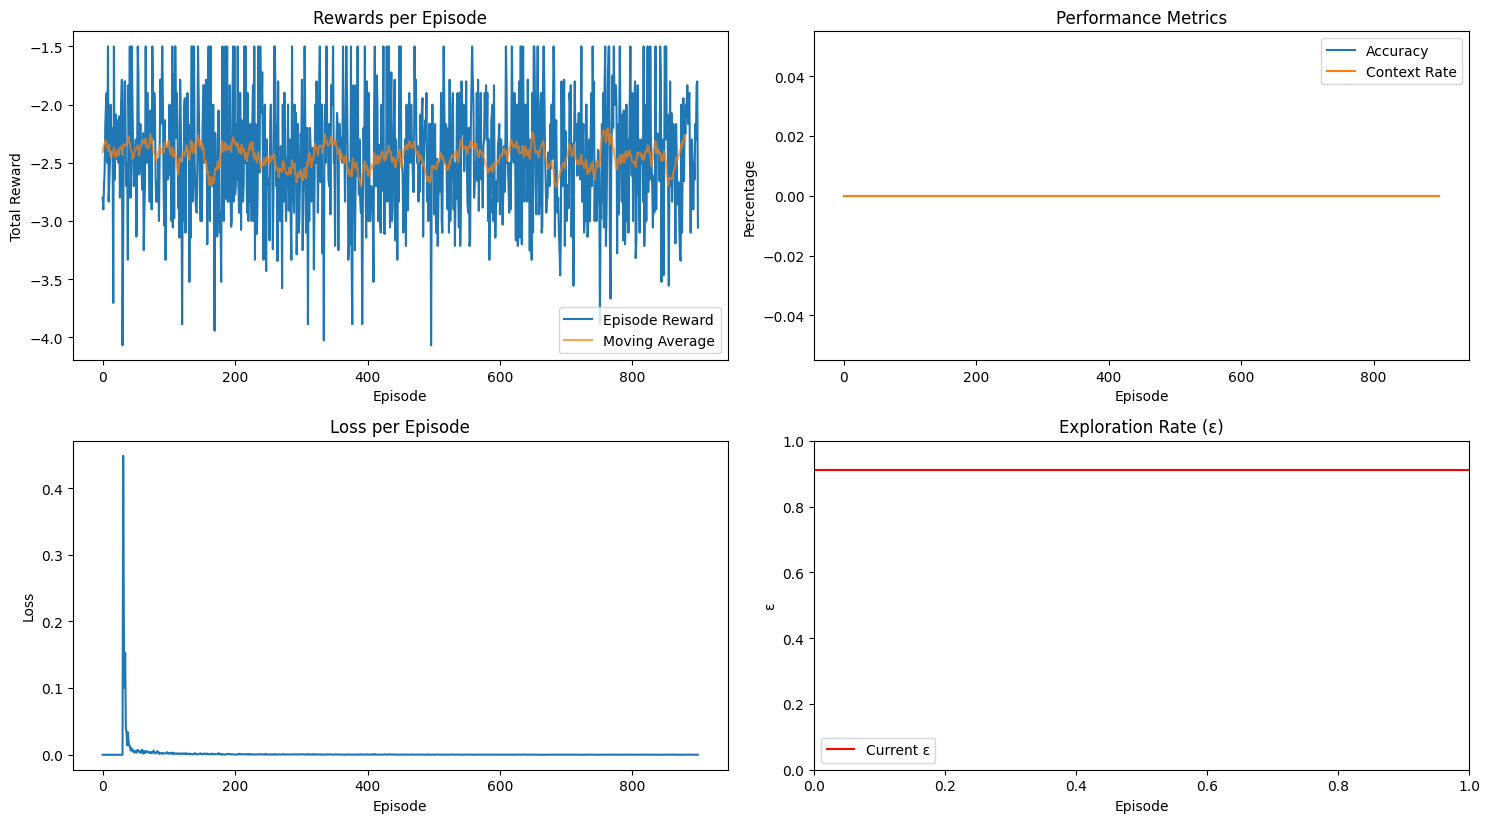

Training Improved DQN:  90%|█████████ | 902/1000 [02:39<00:22,  4.33it/s, Reward=-2.64, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  90%|█████████ | 904/1000 [02:39<00:16,  5.69it/s, Reward=-2.93, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  91%|█████████ | 906/1000 [02:40<00:13,  6.76it/s, Reward=-2.36, Loss=0.0002, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  91%|█████████ | 908/1000 [02:40<00:12,  7.24it/s, Reward=-3.13, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  91%|█████████ | 910/1000 [02:40<00:12,  7.47it/s, Reward=-2.64, Loss=0.0002, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  91%|█████████ | 912/1000 [02:40<00:11,  7.77it/s, Reward=-2.17, Loss=0.0002, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  91%|█████████▏| 914/1000 [02:41<00:10,  7.92it/s, Reward=-3.00, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  92%|█████████▏| 916/1000 [02:41<00:10,  7.79it/s, Reward=-2.47, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  92%|█████████▏| 918/1000 [02:41<00:10,  7.86it/s, Reward=-1.50, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  92%|█████████▏| 920/1000 [02:41<00:10,  7.93it/s, Reward=-3.42, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  92%|█████████▏| 922/1000 [02:42<00:09,  7.91it/s, Reward=-2.30, Loss=0.0002, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  92%|█████████▏| 924/1000 [02:42<00:10,  7.02it/s, Reward=-2.70, Loss=0.0002, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  93%|█████████▎| 926/1000 [02:42<00:10,  6.82it/s, Reward=-1.50, Loss=0.0000, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  93%|█████████▎| 928/1000 [02:43<00:10,  6.75it/s, Reward=-2.30, Loss=0.0002, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  93%|█████████▎| 930/1000 [02:43<00:09,  7.37it/s, Reward=-2.50, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  93%|█████████▎| 932/1000 [02:43<00:09,  7.13it/s, Reward=-2.17, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  93%|█████████▎| 934/1000 [02:43<00:08,  7.46it/s, Reward=-3.00, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  94%|█████████▎| 936/1000 [02:44<00:08,  7.62it/s, Reward=-3.52, Loss=0.0002, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  94%|█████████▍| 938/1000 [02:44<00:07,  7.85it/s, Reward=-2.80, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  94%|█████████▍| 940/1000 [02:44<00:08,  7.31it/s, Reward=-2.70, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  94%|█████████▍| 942/1000 [02:44<00:07,  7.45it/s, Reward=-1.50, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  94%|█████████▍| 944/1000 [02:45<00:07,  7.55it/s, Reward=-2.50, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  95%|█████████▍| 946/1000 [02:45<00:07,  7.45it/s, Reward=-2.20, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  95%|█████████▍| 948/1000 [02:45<00:07,  7.27it/s, Reward=-2.50, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  95%|█████████▌| 950/1000 [02:46<00:06,  7.50it/s, Reward=-2.36, Loss=0.0000, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  95%|█████████▌| 952/1000 [02:46<00:07,  6.80it/s, Reward=-1.50, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  95%|█████████▌| 954/1000 [02:46<00:06,  6.59it/s, Reward=-1.50, Loss=0.0000, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  96%|█████████▌| 956/1000 [02:47<00:06,  6.56it/s, Reward=-2.00, Loss=0.0002, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  96%|█████████▌| 958/1000 [02:47<00:06,  6.59it/s, Reward=-1.50, Loss=0.0001, Epsilon=0.91, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  96%|█████████▌| 960/1000 [02:47<00:06,  6.66it/s, Reward=-1.50, Loss=0.0001, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  96%|█████████▌| 962/1000 [02:47<00:05,  6.65it/s, Reward=-2.24, Loss=0.0001, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  96%|█████████▋| 964/1000 [02:48<00:05,  6.40it/s, Reward=-2.50, Loss=0.0001, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  97%|█████████▋| 966/1000 [02:48<00:05,  6.36it/s, Reward=-2.83, Loss=0.0001, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  97%|█████████▋| 968/1000 [02:48<00:04,  6.60it/s, Reward=-2.25, Loss=0.0000, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  97%|█████████▋| 970/1000 [02:49<00:04,  6.72it/s, Reward=-1.83, Loss=0.0001, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  97%|█████████▋| 972/1000 [02:49<00:04,  6.84it/s, Reward=-2.94, Loss=0.0001, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  97%|█████████▋| 974/1000 [02:49<00:03,  6.76it/s, Reward=-2.07, Loss=0.0001, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  98%|█████████▊| 976/1000 [02:50<00:03,  6.25it/s, Reward=-2.93, Loss=0.0001, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  98%|█████████▊| 978/1000 [02:50<00:03,  6.64it/s, Reward=-2.83, Loss=0.0000, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  98%|█████████▊| 980/1000 [02:50<00:02,  7.03it/s, Reward=-2.64, Loss=0.0002, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  98%|█████████▊| 982/1000 [02:50<00:02,  7.37it/s, Reward=-1.90, Loss=0.0002, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  98%|█████████▊| 984/1000 [02:51<00:02,  7.61it/s, Reward=-3.16, Loss=0.0001, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  99%|█████████▊| 986/1000 [02:51<00:01,  7.82it/s, Reward=-1.90, Loss=0.0001, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  99%|█████████▉| 988/1000 [02:51<00:01,  7.60it/s, Reward=-2.59, Loss=0.0001, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  99%|█████████▉| 990/1000 [02:51<00:01,  7.92it/s, Reward=-2.00, Loss=0.0000, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  99%|█████████▉| 992/1000 [02:52<00:01,  7.99it/s, Reward=-2.50, Loss=0.0000, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN:  99%|█████████▉| 994/1000 [02:52<00:00,  7.91it/s, Reward=-2.83, Loss=0.0000, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN: 100%|█████████▉| 996/1000 [02:52<00:00,  7.70it/s, Reward=-2.25, Loss=0.0001, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN: 100%|█████████▉| 998/1000 [02:52<00:00,  7.98it/s, Reward=-2.80, Loss=0.0002, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


Training Improved DQN: 100%|█████████▉| 999/1000 [02:53<00:00,  8.01it/s, Reward=-2.93, Loss=0.0001, Epsilon=0.90, Acc=0.0%, Context=0.0%]

0
0


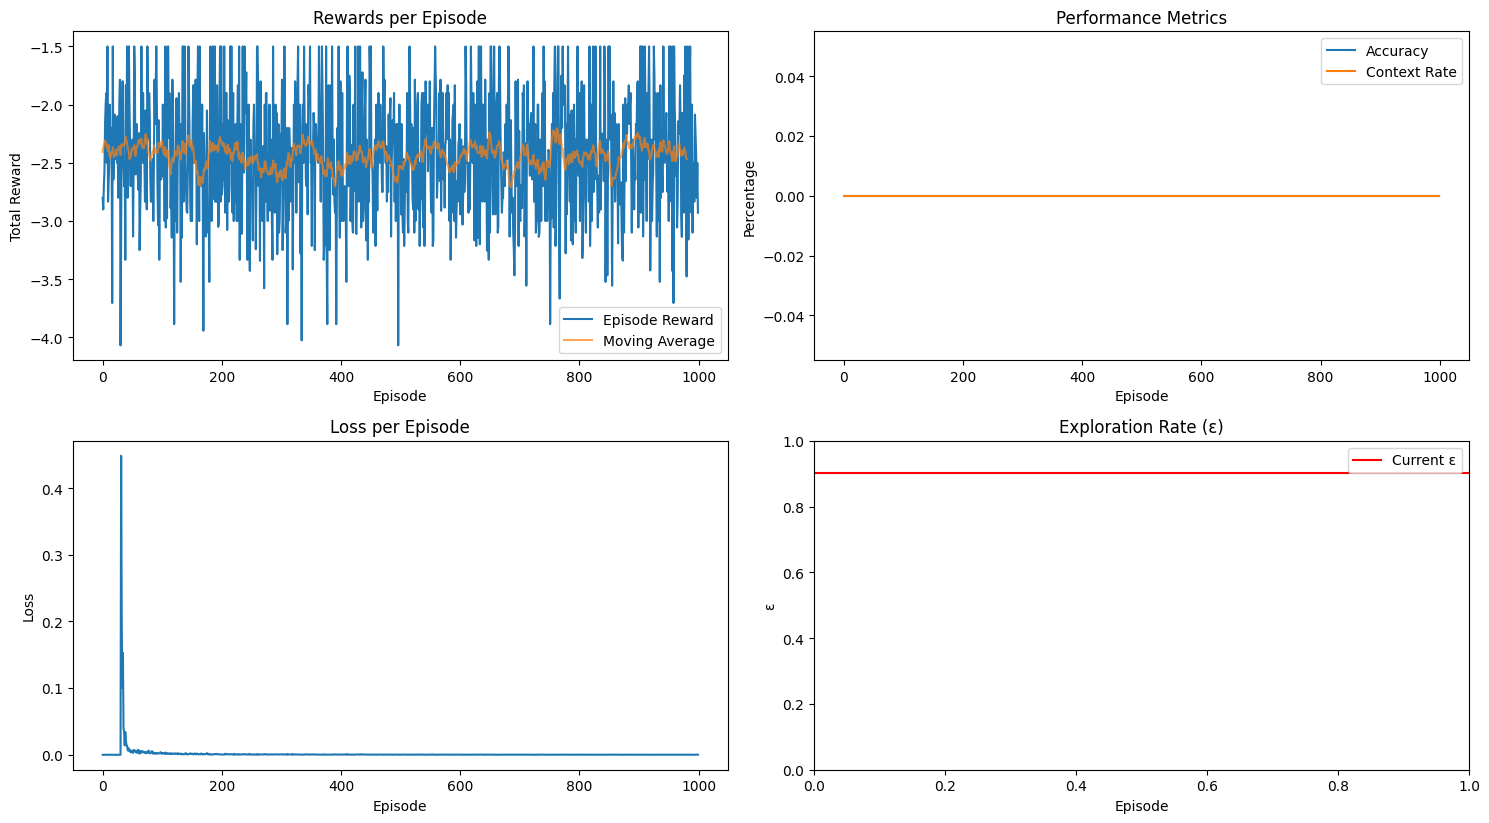

Training Improved DQN: 100%|██████████| 1000/1000 [02:53<00:00,  5.75it/s, Reward=-2.93, Loss=0.0001, Epsilon=0.90, Acc=0.0%, Context=0.0%]


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

class EnhancedNextWordPredictor(nn.Module):
    def __init__(self, bert_model, vocab_size):
        super(EnhancedNextWordPredictor, self).__init__()
        self.bert = bert_model
        self.attention = nn.MultiheadAttention(embed_dim=bert_model.config.hidden_size,
                                             num_heads=4,
                                             batch_first=True)
        self.fc = nn.Linear(bert_model.config.hidden_size, vocab_size)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask=attention_mask).last_hidden_state
        attn_output, _ = self.attention(bert_output, bert_output, bert_output)
        last_token_output = attn_output[:, -1, :]  # Use the last token's output
        logits = self.fc(last_token_output)        # Predict vocab probabilities
        return logits

def initialize_model_for_training(checkpoint_path, device):
    """
    Initialize the model with pretrained weights for continued training

    Args:
        checkpoint_path: Path to your saved .pth model
        device: torch device (cuda/cpu)
    """
    # Initialize the tokenizer and base BERT model
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert_model = BertModel.from_pretrained("bert-base-uncased")
    vocab_size = len(tokenizer.get_vocab())

    # Initialize the model with the same architecture
    model = EnhancedNextWordPredictor(bert_model, vocab_size).to(device)

    # Load the pretrained weights
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # If the checkpoint contains the full state dict
    if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
        model.load_state_dict(checkpoint['model_state_dict'])
        print("Loaded pretrained weights from state dict in checkpoint")
    else:
        # If the checkpoint is just the state dict directly
        model.load_state_dict(checkpoint)
        print("Loaded pretrained weights directly from checkpoint")

    return model, tokenizer

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_path = "/content/drive/MyDrive/nlp_research/best_model.pth"

try:
    model, tokenizer = initialize_model_for_training(pretrained_path, device)
    print("Successfully loaded model and tokenizer")

    # Now train with the improved DQN implementation
    rewards, accuracies, context_rates, losses = train_improved_dqn(
        model=model,
        corpus_path="/content/drive/MyDrive/nlp_research/english_corpus_selected_movies.txt",
        tokenizer=tokenizer,
        device=device,
        episodes=1000,  # Adjust as needed
        batch_size=32,
        save_interval=100,
        save_path='/content/drive/MyDrive/nlp_research/improved_dqn_checkpoints'
    )

except Exception as e:
    print(f"Error during initialization: {str(e)}")

In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from torch.optim import Adam
import numpy as np
from collections import deque
from torch.utils.data import Dataset

class EnhancedNextWordPredictor(nn.Module):
    def __init__(self, bert_model, vocab_size):
        super(EnhancedNextWordPredictor, self).__init__()
        self.bert = bert_model
        self.attention = nn.MultiheadAttention(embed_dim=bert_model.config.hidden_size,
                                             num_heads=4,
                                             batch_first=True)
        self.fc = nn.Linear(bert_model.config.hidden_size, vocab_size)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask=attention_mask).last_hidden_state
        attn_output, _ = self.attention(bert_output, bert_output, bert_output)
        last_token_output = attn_output[:, -1, :]  # Use the last token's output
        logits = self.fc(last_token_output)        # Predict vocab probabilities
        return logits

class ImprovedDQNAgent:
    def __init__(self, model, tokenizer, device, memory_size=10000, gamma=0.95,
                 epsilon_start=1.0, epsilon_end=0.01, epsilon_decay_steps=10000):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device
        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay_steps = epsilon_decay_steps
        self.memory = deque(maxlen=memory_size)
        self.optimizer = Adam(model.parameters(), lr=0.001)
        self.vocab_size = len(tokenizer.get_vocab())
        self.steps = 0

    def update_epsilon(self):
        """Linear epsilon decay"""
        self.epsilon = max(
            self.epsilon_end,
            self.epsilon - (1.0 - self.epsilon_end) / self.epsilon_decay_steps
        )
        self.steps += 1

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() <= self.epsilon:
            # Improved exploration: sometimes choose from top-k most likely words
            with torch.no_grad():
                state_input = {k: v.to(self.device) for k, v in state.items()}
                q_values = self.model(state_input['input_ids'], state_input['attention_mask'])
                if random.random() < 0.3:  # 30% of exploration uses top-k
                    k = 10
                    top_k_actions = torch.topk(q_values, k).indices[0]
                    action = torch.zeros_like(q_values)
                    action[0, random.choice(top_k_actions)] = 1.0
                    return action
                else:
                    return torch.randn_like(q_values)

        with torch.no_grad():
            state_input = {k: v.to(self.device) for k, v in state.items()}
            q_values = self.model(state_input['input_ids'], state_input['attention_mask'])
            return q_values

    def compute_td_loss(self, batch_size):
        if len(self.memory) < batch_size:
            return 0

        minibatch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)

        # Convert to tensors and move to device
        states = {k: torch.cat([s[k] for s in states]) for k in states[0].keys()}
        next_states = {k: torch.cat([s[k] for s in next_states]) for k in next_states[0].keys()}
        actions = torch.stack([torch.argmax(a) if len(a.shape) > 1 else a for a in actions])
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        # Compute current Q values
        current_q_values = self.model(states['input_ids'].to(self.device),
                                    states['attention_mask'].to(self.device))
        current_q_values = current_q_values.gather(1, actions.unsqueeze(1).to(self.device))

        # Compute next Q values
        with torch.no_grad():
            next_q_values = self.model(next_states['input_ids'].to(self.device),
                                     next_states['attention_mask'].to(self.device))
            max_next_q_values = next_q_values.max(1)[0]
            expected_q_values = rewards + (1 - dones) * self.gamma * max_next_q_values

        # Compute loss using Huber loss for stability
        loss = torch.nn.SmoothL1Loss()(current_q_values, expected_q_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
        self.optimizer.step()

        return loss.item()

class ImprovedRewardSystem:
    def __init__(self, corpus_dataset, tokenizer, window_size=1000):
        self.corpus_dataset = corpus_dataset
        self.tokenizer = tokenizer
        self.context_frequency = {}
        self.window_size = window_size
        self.recent_predictions = deque(maxlen=window_size)
        self.recent_context_matches = deque(maxlen=window_size)
        self.build_context_map()

    def build_context_map(self):
        """Build n-gram frequency map from corpus with positional weighting"""
        print("Building context map...")
        for context, target in tqdm(self.corpus_dataset.samples):
            context_key =''.join(context)
            if context_key not in self.context_frequency:
                self.context_frequency[context_key] = {}
            if target not in self.context_frequency[context_key]:
                self.context_frequency[context_key][target] = 0
            self.context_frequency[context_key][target] += 1

    def get_context_score(self, context, predicted_word):
        """Calculate context score with position-aware weighting"""
        context_key =''.join(context)
        if context_key not in self.context_frequency:
            return 0.0

        total_occurrences = sum(self.context_frequency[context_key].values())
        word_occurrences = self.context_frequency[context_key].get(predicted_word, 0)

        base_score = word_occurrences / total_occurrences if total_occurrences > 0 else 0.0

        # Add positional weighting
        position_weight = 1.0
        for i, word in enumerate(context):
            if word == predicted_word:
                position_weight *= 0.8 ** (len(context) - i)  # Decay factor for distance

        return base_score * position_weight

    def calculate_dynamic_reward(self, predicted_word, target_word, context):
        """Calculate reward with multiple components"""
        # Basic correctness reward
        is_correct = (predicted_word == target_word)
        self.recent_predictions.append(is_correct)

        # Context alignment reward
        context_score = self.get_context_score(context, predicted_word)
        self.recent_context_matches.append(context_score > 0)

        # Calculate running metrics
        accuracy = sum(self.recent_predictions) / len(self.recent_predictions)
        context_rate = sum(self.recent_context_matches) / len(self.recent_context_matches)

        # Base reward calculation
        base_reward = 10.0 if is_correct else -5.0

        # Context bonus
        context_bonus = context_score * 5.0

        # Length similarity bonus
        length_similarity = 1.0 - (abs(len(predicted_word) - len(target_word)) / max(len(predicted_word), len(target_word)))
        length_bonus = length_similarity * 2.0

        # Semantic similarity bonus (using token overlap as proxy)
        pred_tokens = set(self.tokenizer.encode(predicted_word))
        target_tokens = set(self.tokenizer.encode(target_word))
        token_overlap = len(pred_tokens.intersection(target_tokens)) / len(pred_tokens.union(target_tokens))
        semantic_bonus = token_overlap * 3.0

        # Combine all components
        total_reward = base_reward + context_bonus + length_bonus + semantic_bonus

        # Scale reward based on recent performance to maintain challenge
        performance_scalar = 1.0 - (accuracy * 0.5)  # Reduce rewards as accuracy improves
        total_reward *= performance_scalar

        return total_reward, {
            'accuracy': accuracy * 100,
            'context_rate': context_rate * 100,
            'base_reward': base_reward,
            'context_bonus': context_bonus,
            'length_bonus': length_bonus,
          'semantic_bonus': semantic_bonus
        }

class ImprovedWordPredictionEnvironment:
    def __init__(self, tokenizer, corpus_dataset):
        self.tokenizer = tokenizer
        self.corpus_dataset = corpus_dataset
        self.reward_system = ImprovedRewardSystem(corpus_dataset, tokenizer)
        self.current_state = None
        self.target_word = None
        self.current_context = None
        self.episode_rewards = []
        self.samples = corpus_dataset.samples

    def reset(self):
        context, target = random.choice(self.samples)
        self.current_context = context
        self.target_word = target
        input_ids = self.tokenizer.encode(' '.join(context[:2]), return_tensors='pt')
        attention_mask = self.tokenizer.encode(' '.join(context[:2]), return_tensors='pt', max_length=6, padding='max_length', truncation=True)[1]
        self.current_state = {
            'input_ids': input_ids,
            'attention_mask': attention_mask
        }
        return self.current_state

    def step(self, action):
        predicted_word = self.tokenizer.decode([torch.argmax(action).item()])
        reward, info = self.reward_system.calculate_dynamic_reward(predicted_word, self.target_word, self.current_context)
        self.episode_rewards.append(reward)

        # Update state
        done = True
        next_state = self.reset()
        return next_state, reward, done, info

class CustomCorpusDataset(Dataset):
    def __init__(self, corpus_path, tokenizer, context_size=3):
        """
        Initialize the dataset with a corpus file and tokenizer.

        Args:
            corpus_path (str): Path to the text corpus file
            tokenizer: The tokenizer to use for encoding text
            context_size (int): Number of words to use as context for prediction
        """
        self.tokenizer = tokenizer
        self.context_size = context_size
        self.samples = []

        # Read and process the corpus
        with open(corpus_path, 'r', encoding='utf-8') as f:
            text = f.read().strip()

        # Split into sentences and words
        sentences = [sent.strip() for sent in text.split('.') if sent.strip()]

        # Create context-target pairs
        for sentence in sentences:
            words = sentence.split()
            if len(words) <= context_size:
                continue

            # Generate samples using sliding window
            for i in range(len(words) - context_size):
                context = words[i:i + context_size-1]
                target = words[i + context_size-1]
                self.samples.append((context, target))

    def __len__(self):
        """Return the number of samples in the dataset"""
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Get a single sample from the dataset.

        Args:
            idx (int): Index of the sample to retrieve

        Returns:
            tuple: (context_tensor, target_tensor)
        """
        context, target = self.samples[idx]

        # Encode context and target
        context_encoding = self.tokenizer(
          ''.join(context),
            return_tensors='pt',
            max_length=6,
            padding='max_length',
            truncation=True
        )

        target_encoding = self.tokenizer(
            target,
            return_tensors='pt',
            max_length=6,
            padding='max_length',
            truncation=True
        )

        return {
            'context': context_encoding,
            'target': target_encoding['input_ids'].squeeze(),
            'raw_context': context,
            'raw_target': target
        }

def initialize_model_for_training(checkpoint_path, device):
    """
    Initialize the model with pretrained weights for continued training

    Args:
        checkpoint_path: Path to your saved.pth model
        device: torch device (cuda/cpu)
    """
    if not os.path.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint path '{checkpoint_path}' does not exist")

    try:
        # Initialize the tokenizer and base BERT model
        tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
        bert_model = BertModel.from_pretrained("bert-base-uncased")
        vocab_size = len(tokenizer.get_vocab())

        # Initialize the model with the same architecture
        model = EnhancedNextWordPredictor(bert_model, vocab_size).to(device)

        # Load the pretrained weights
        checkpoint = torch.load(checkpoint_path, map_location=device)

        # If the checkpoint contains the full state dict
        if isinstance(checkpoint, dict) and'model_state_dict' in checkpoint:
            model.load_state_dict(checkpoint['model_state_dict'])
            print("Loaded pretrained weights from state dict in checkpoint")
        else:
            # If the checkpoint is just the state dict directly
            model.load_state_dict(checkpoint)
            print("Loaded pretrained weights directly from checkpoint")

        return model, tokenizer
    except Exception as e:
        print(f"Error during initialization: {str(e)}")
        return None, None

def train_improved_dqn(model, corpus_path, tokenizer, device,
                      episodes=1000, batch_size=32,
                      save_interval=100, save_path='improved_dqn_checkpoints'):
    # Initialize environment and agent
    corpus_dataset = CustomCorpusDataset(corpus_path, tokenizer)
    env = ImprovedWordPredictionEnvironment(tokenizer, corpus_dataset)
    agent = ImprovedDQNAgent(model, tokenizer, device)

    # Tracking metrics
    rewards_history = []
    accuracy_history = []
    context_rate_history = []
    losses_history = []
    best_reward = float('-inf')

    os.makedirs(save_path, exist_ok=True)

    progress_bar = tqdm(range(episodes), desc='Training Improved DQN')
    for episode in progress_bar:
        state = env.reset()
        total_reward = 0
        episode_loss = 0
        done = False
        correct_predictions = 0
        total_contexts = 0

        while not done:
            # Get action and interact with environment
            action = agent.act(state)
            next_state, reward, done, info = env.step(action)

            # Store experience and update agent
            agent.remember(state, action, reward, next_state, done)
            loss = agent.compute_td_loss(batch_size)

            state = next_state
            total_reward += reward
            episode_loss += loss if loss else 0

            # Update exploration rate
            agent.update_epsilon()

            # Track correct predictions and context matches
            if info:
                if info['accuracy'] > 0:
                    correct_predictions += 1
                total_contexts += 1

        # Record metrics
        avg_loss = episode_loss / (episode + 1)
        rewards_history.append(total_reward)
        losses_history.append(avg_loss)

        # Calculate accuracy and context rate
        episode_accuracy = correct_predictions / (episode + 1) if episode > 0 else 0
        episode_context_rate = 0

        accuracy_history.append(episode_accuracy)
        context_rate_history.append(episode_context_rate)

        # Update progress bar
        progress_bar.set_postfix({
            'Reward': f'{total_reward:.2f}',
            'Loss': f'{avg_loss:.4f}',
            'Epsilon': f'{agent.epsilon:.2f}',
            'Acc': f'{episode_accuracy*100:.1f}%',
            'Context': f'{episode_context_rate*100:.1f}%'
        })

        # Save best model
        if total_reward > best_reward:
            best_reward = total_reward
            torch.save({
                'episode': episode,
            'model_state_dict': model.state_dict(),
                'optimizer_state_dict': agent.optimizer.state_dict(),
            'reward': best_reward,
                'epsilon': agent.epsilon
            }, f'{save_path}/best_model.pth')

        # Plot training progress
        if (episode + 1) % save_interval == 0:
            plt.figure(figsize=(15, 12))

            # Plot rewards
            plt.subplot(3, 2, 1)
            plt.plot(rewards_history, label='Episode Reward')
            plt.plot(np.convolve(rewards_history, np.ones(20)/20, mode='valid'),
                     label='Moving Average', alpha=0.7)
            plt.title('Rewards per Episode')
            plt.xlabel('Episode')
            plt.ylabel('Total Reward')
            plt.legend()

            # Plot accuracy and context rate
            plt.subplot(3, 2, 2)
            plt.plot(accuracy_history, label='Accuracy')
            plt.plot(context_rate_history, label='Context Rate')
            plt.title('Performance Metrics')
            plt.xlabel('Episode')
            plt.ylabel('Percentage')
            plt.legend()

            # Plot loss
            plt.subplot(3, 2, 3)
            plt.plot(losses_history)
            plt.title('Loss per Episode')
            plt.xlabel('Episode')
            plt.ylabel('Loss')

            # Plot epsilon decay
            plt.subplot(3, 2, 4)
            plt.axhline(y=agent.epsilon, color='r', linestyle='-', label='Current ε')
            plt.title('Exploration Rate (ε)')
            plt.xlabel('Episode')
            plt.ylabel('ε')
            plt.legend()

            plt.tight_layout()
            plt.show()

    return rewards_history, accuracy_history, context_rate_history, losses_history

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_path = "/content/drive/MyDrive/nlp_research/best_model.pth"

try:
    model, tokenizer = initialize_model_for_training(pretrained_path, device)
    print("Successfully loaded model and tokenizer")

    # Now train with the improved DQN implementation
    rewards, accuracies, context_rates, losses = train_improved_dqn(
        model=model,
        corpus_path="/content/drive/MyDrive/nlp_research/english_corpus_selected_movies.txt",
        tokenizer=tokenizer,
        device=device,
        episodes=1000,  # Adjust as needed
        batch_size=32,
        save_interval=100,
        save_path='/content/drive/MyDrive/nlp_research/improved_dqn_checkpoints'
    )

except Exception as e:
    print(f"Error during initialization: {str(e)}")